# Nettoyage des données
Created by: Thomas Durand-Texte, Jan. 2023
***

# Imports
## Import des packages

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option("display.max_columns", 200)
import missingno as msno

import datetime as dt
import scipy.stats as st


import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


import tools
cm = 1./2.54


## Reload module (for updates)

In [2]:
import importlib
cm = 1./2.54
importlib.reload(tools)
tools.set_theme( white_font=True )
# tools.plot_test_figure()

## Lectures des différentes catégories

In [3]:
with open('openfood_OC.csv' , 'r') as file:
    categories_0 = file.readline()[:-1].split('\t')
    # print('n \\t: {:}'.format( len(line.split('\t')) ) )
    # print(line)
    # while True:
    #     line = file.readline()[:-1]
    #     if line is None: break    
    # print(file.readline())
    # print(file.readline())
print('categories:', categories_0 )

categories: ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil',

## Définitions keys to keep

In [4]:
# lst of keywords for categories that must be kept
keep_keys = '|'.join( ['nutriscore', 'labels'] )
drop_keys = '|'.join( ['image', 'brand', 'url', 'packaging', 'emb_code', 
                        'cities', 'purchase', 'stores' , 'serving', 'states',
                        'creator', 'created'] )

categories = pd.Series( categories_0 )[~pd.Series( categories_0 ).str.contains( drop_keys ) ]
# print( categories_to_load )
del drop_keys

## Chargement des données
- Pour tout string -> lower
- sauvegarde avec pickle pour recharge plus rapide

In [5]:
data = pd.DataFrame()

# CATEGORY TO BE SET LATER
# dtypes = { key:'category' for key in ['nova_group', 'nutriscore_grade'] }

dtypes = {}
for key in ['code', 'traces', 'traces_en', 'traces_tags',
            'origins_en', 'origins_tags', 'purchase_places',
            'manufacturing_places', 'manufacturing_places_tags',
            'origins', 'food_groups_tags','ingredients_from_palm_oil_tags',
            'ingredients_that_may_be_from_palm_oil_tags',
            'emb_codes_tags', 'food_groups', 'food_groups_en',
            'cities_tags', 'ecoscore_grade_fr', 'emb_codes',
            'allergens', 'additives',
            'nova_group', 'nutriscore_grade'
            ]:
    dtypes[key]= 'object'


# data = dd.read_csv( 'openfood_OC.csv', delimiter='\t', usecols=categories, dtype=dtypes )
# data = data.compute()


if False:
    # load data to DataFrame
    data = pd.read_csv( 'openfood_OC.csv', delimiter='\t', usecols=categories, dtype=dtypes )
    
    # lower all string except grade
    for key in data.keys():
        if data[key].dtype == 'object':
            if 'grade' in key.__str__(): # upper for nutriscore_grade
                data[key] = data[key].str.upper()
            else:
                data[key] = data[key].str.lower()
        
    # Save to compressed format for faster reload
    data.to_pickle( 'data0.pkl')
else:
    data = pd.read_pickle( 'data0.pkl' )
# data.head()

# dtype = { 'nova_group':'category', 'nutriscore_grade':'category', 'additives': 'object' , 'abbreviated_product_name': 'object', 'allergens': 'object', 'cities_tags': 'object', 'code': 'object', 'ecoscore_grade_fr': 'object', 'emb_codes': 'object', 'emb_codes_tags': 'object', 'first_packaging_code_geo': 'object', 'food_groups': 'object', 'food_groups_en': 'object', 'food_groups_tags': 'object', 'generic_name': 'object', 'ingredients_from_palm_oil_tags': 'object', 'ingredients_that_may_be_from_palm_oil_tags': 'object', 'manufacturing_places': 'object', 'manufacturing_places_tags': 'object', 'origins': 'object', 'origins_en': 'object', 'origins_tags': 'object', 'packaging_text': 'object', 'purchase_places': 'object', 'traces': 'object', 'traces_en': 'object', 'traces_tags': 'object'}



# data = dd.read_csv('openfood_OC.csv', delimiter ='\t', dtype=dtype)
# data = data.compute()

# # data = pd.read_csv('openfood_OC.csv', delimiter='\t', dtype=dtype)
# data.head()

***
# Gestion des doublons

## Détection et gestion des doublons
* doublons complets: <span style="color:orange"> $\rightarrow$ pas de doublon complet sur ce jeu de données </span>

1. code: <span style="color:orange">  prendre le plus récent ou le plus complet si même date </span>
2. si même date: <span style="color:orange"> prendre le plus complet </span>

In [6]:
duplicated_codes = data['code'].duplicated(keep=False)

# duplicated_full = data.loc[duplicated_codes,:].duplicated(keep=False)
# display( duplicated_full )

df_tmp = data.loc[duplicated_codes, :].copy()
df_tmp['n filled'] = len(data.keys()) - df_tmp.isnull().sum(1)

df_tmp.sort_values( by=['code', 'last_modified_datetime', 'n filled'] , inplace=True )

print('DataFrame of the duplicated rows (code)')
display( df_tmp[ ['code', 'last_modified_datetime', 'n filled'] ] )

indexes_to_drop = df_tmp.index[::2] 

if len(indexes_to_drop) > 0:
    print('indexes of rows to drop:', indexes_to_drop )
    data.drop( index= df_tmp.index[::2] , inplace=True )
else:
    print('no row to drop')

del df_tmp, indexes_to_drop

DataFrame of the duplicated rows (code)


,code,last_modified_datetime,n filled
421527,31843340000818,2021-08-17t06:35:03z,28
349035,31843340000818,2022-02-11t08:47:36z,30
61995,3560070278831,2021-04-17t07:44:17z,41
188851,3560070278831,2022-02-10t18:03:06z,47
270028,3700320230572,2021-08-24t12:58:09z,16
749882,3700320230572,2021-08-24t12:58:58z,33
480000,7071688002962,2021-07-13t14:26:35z,40
477267,7071688002962,2021-07-13t14:26:35z,45


indexes of rows to drop: Int64Index([421527, 61995, 270028, 480000], dtype='int64')


***
# Analyse des NaN
## Décompte des NaN

In [7]:
n = len(data) # number of samples
data_isna = data.isna()
df_croisement = {}

## Vendu en France ?

In [8]:
keys = data.keys()[ data.keys().str.contains('countr') ]
display( 'Keys linked to countries:', keys.tolist() )

display( 'Sum ina:', data_isna[keys].sum(0) )

df_croisement = {}
df_croisement['countries'] = tools.croisement_NaN_counts( data_isna, keys )

print('Croisement NaN countries:')
display( df_croisement['countries'] )

# display( data.loc[ ~data_isna['countries'] & data_isna['countries_tags'] , keys])

target_country = 'france'
contains_france = { key: data[key].str.contains( target_country ) for key in keys }


contains_france = { key: data[key].str.contains( target_country ) for key in keys }
sr_country_ok = contains_france['countries'] | contains_france['countries_tags'] | contains_france['countries_en']

print('number of row containing france in:')
print( 'countries:', contains_france['countries'].sum() ) 
print( 'countries_tags:', contains_france['countries_tags'].sum() ) 
print( 'countries_en:', contains_france['countries_en'].sum() ) 
print( 'countries | countries_tags:', (contains_france['countries'] | contains_france['countries_tags'] ).sum() ) 
print( 'countries | countries_en:', (contains_france['countries'] | contains_france['countries_en'] ).sum() ) 
print( 'any of the three:', sr_country_ok.sum() ) 

# keep only data of the target country
data.drop( data.index[ ~sr_country_ok ] , inplace=True ) 
data_isna.drop( data_isna.index[ ~sr_country_ok ] , inplace=True )

if True: 
    data.drop( columns=keys, inplace=True )
    data_isna.drop( columns=keys, inplace=True )

data = data.reset_index()
data_isna = data_isna.reset_index()
del sr_country_ok, contains_france

'Keys linked to countries:'

['countries', 'countries_tags', 'countries_en']

'Sum ina:'

countries         2300
countries_tags    2301
countries_en      2301
dtype: int64

Croisement NaN countries:


,isna(countries),isna(countries_tags),isna(countries_en)
~isna(countries),0,1,1
~isna(countries_tags),0,0,0
~isna(countries_en),0,0,0


number of row containing france in:
countries: 216447
countries_tags: 321629
countries_en: 321629
countries | countries_tags: 321630
countries | countries_en: 321630
any of the three: 321630


## Nom produit

In [9]:
keys = data.keys()[ data.keys().str.contains('name') ]
display( 'Keys linked to name:', keys.tolist() )

display( 'len(data):', len(data) )
display( 'Sum ina:', data_isna[keys].sum(0) )

df_croisement['name'] = tools.croisement_NaN_counts( data_isna, keys )
print('Croisement NaN name:')
display( df_croisement['name'] )

sr_loc = data_isna['product_name'] & ~data_isna['generic_name']
data.loc[ sr_loc , ['product_name'] ] = data['generic_name']
data_isna.loc[ sr_loc, 'product_name'] = False

sr_loc = data_isna['product_name'] & ~data_isna['abbreviated_product_name']
data.loc[ sr_loc , ['product_name'] ] = data['abbreviated_product_name']
data_isna.loc[ sr_loc, 'product_name'] = False

del sr_loc

df_croisement['name'] = tools.croisement_NaN_counts( data_isna, keys )

display( 'Sum ina:', data_isna[keys].sum(0) )
print('Croisement NaN name:')
display( df_croisement['name'] )


# keep only data of with a product_name
data.drop( data.index[ data_isna['product_name'] ] , inplace=True ) 
data_isna.drop( data_isna.index[ data_isna['product_name'] ] , inplace=True )
data = data.reset_index()
data_isna = data_isna.reset_index()

'Keys linked to name:'

['product_name', 'abbreviated_product_name', 'generic_name']

'len(data):'

321630

'Sum ina:'

product_name                  8576
abbreviated_product_name    318772
generic_name                291021
dtype: int64

Croisement NaN name:


,isna(product_name),isna(abbreviated_product_name),isna(generic_name)
~isna(product_name),0,310337,282502
~isna(abbreviated_product_name),141,0,344
~isna(generic_name),57,28095,0


'Sum ina:'

product_name                  8391
abbreviated_product_name    318772
generic_name                291021
dtype: int64

Croisement NaN name:


,isna(product_name),isna(abbreviated_product_name),isna(generic_name)
~isna(product_name),0,310381,282630
~isna(abbreviated_product_name),0,0,344
~isna(generic_name),0,28095,0


## Catégories
- pnns_groups: unknown -> NaN
- food_groups: "en:"->"" & '-'->' '

<span style="color:red"> drop values nan ? </span>

In [10]:
keys = data.keys()[ (data.keys().str.contains('group|catego')) & ~(data.keys().str.contains('nova')) ]
print( 'Keys linked to group/category:', keys.tolist() )


# replace "en:" and "-" in food_groups to improve readability
data['food_groups'] = data['food_groups'].str.replace( 'en:' , '' , regex=False )
data['food_groups'] = data['food_groups'].str.replace( '-', ' ' , regex=False )

# replace 'unknown' to NaN
data.replace( {key:'unknown' for key in keys }, np.nan, inplace=True )
# data.replace( { 'pnns_groups_1':{'unknown':np.nan},
#                 'pnns_groups_2':{'unknown':np.nan} }, inplace=True )

data_isna[keys] = data[keys].isna()



print( '\nSum ina:')
print( data_isna[keys].sum(0) )


df_croisement['category'] = tools.croisement_NaN_counts( data_isna, keys )

print('\nCroisement NaN category:')
display( df_croisement['category'] )

# display( data.loc[ data_isna['pnns_groups_1'] , ['product_name', 'generic_name'] ] )


if False:
    data.drop( columns=keys[ ~(keys.str.contains('pnns_groups'))] , inplace=True )
    data_isna.drop( columns=keys[ ~(keys.str.contains('pnns_groups'))] , inplace=True )

if False:
    data.drop( data.index[ data_isna['pnns_groups_1'] ] , inplace=True ) 
    data_isna.drop( data_isna.index[ data_isna['pnns_groups_1'] ] , inplace=True )
    data = data.reset_index()
    data_isna = data_isna.reset_index()

Keys linked to group/category: ['categories', 'categories_tags', 'categories_en', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'main_category', 'main_category_en']

Sum ina:
categories          161334
categories_tags     161335
categories_en       161335
pnns_groups_1       179241
pnns_groups_2       179241
food_groups         179045
food_groups_tags    179017
food_groups_en      179045
main_category       161335
main_category_en    161335
dtype: int64

Croisement NaN category:


,isna(categories),isna(categories_tags),isna(categories_en),isna(pnns_groups_1),isna(pnns_groups_2),isna(food_groups),isna(food_groups_tags),isna(food_groups_en),isna(main_category),isna(main_category_en)
~isna(categories),0,1,1,17907,17907,17711,17683,17711,1,1
~isna(categories_tags),0,0,0,17906,17906,17710,17682,17710,0,0
~isna(categories_en),0,0,0,17906,17906,17710,17682,17710,0,0
~isna(pnns_groups_1),0,0,0,0,0,20,20,20,0,0
~isna(pnns_groups_2),0,0,0,0,0,20,20,20,0,0
~isna(food_groups),0,0,0,216,216,0,0,0,0,0
~isna(food_groups_tags),0,0,0,244,244,28,0,28,0,0
~isna(food_groups_en),0,0,0,216,216,0,0,0,0,0
~isna(main_category),0,0,0,17906,17906,17710,17682,17710,0,0
~isna(main_category_en),0,0,0,17906,17906,17710,17682,17710,0,0


## Remplissage pnns_groups_1

data chi: 313239
nan in data_chi:
pnns_groups_1    179241
pnns_groups_2    179241
food_groups      179045
main_category    161335
dtype: int64

nan in data_chi:
pnns_groups_1    179241
pnns_groups_2    179241
food_groups      179045
main_category    161335
dtype: int64


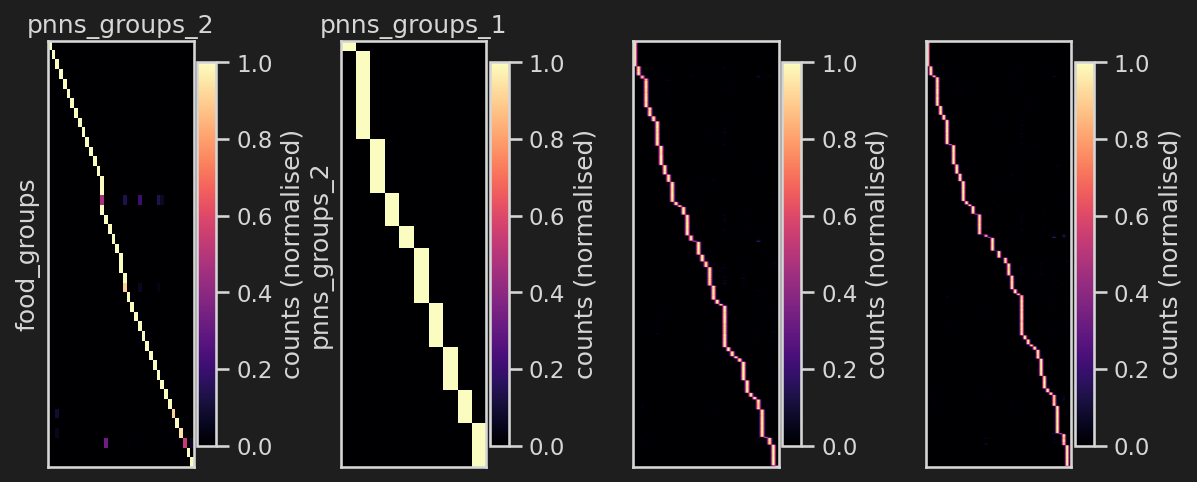

In [11]:
keys = ['pnns_groups_1', 'pnns_groups_2', 'food_groups', 'main_category']
data_chi = data[keys].copy()

print('data chi:', len(data_chi))
print('nan in data_chi:')
print( data_chi.isna().sum() )


# fig, ax = plt.subplots( figsize=(10*cm,10*cm))
# msno.heatmap( data_chi , ax=ax )

data_chi_isnull = data_chi.isnull()

# drop all rows with at least one NaN
# data_chi.drop( data_chi.index[ data_chi_isnull.sum(1) > 0 ] , inplace=True )

# check drop
print('\nnan in data_chi:')
print( data_chi.isnull().sum() )

type_plot = ['xi', 'count'][1]

X4, Y4 = 'main_category', 'food_groups'
X3, Y3 = 'main_category', 'pnns_groups_2'
X2, Y2 = 'pnns_groups_2', 'pnns_groups_1'
X1, Y1 = 'food_groups', 'pnns_groups_2'

maps = [ None, None, None, None ]
fig, axs = plt.subplots( 1,4, figsize= (20*cm, 8*cm) )
for i, (X,Y) in enumerate( [ (X1,Y1), (X2,Y2) , (X3,Y3), (X4,Y4) ] ):
    xi_ij, contingences = tools.chi2( data_chi.drop( data_chi.index[ data_chi_isnull[[X,Y]].sum(1) > 0 ] ), X, Y )

    image = contingences.values
    image = image[:-1,:-1] / image[:-1,-1:]
    argmax_col = image.argmax(1)
    maps[i] = pd.Series( { key_in:contingences.keys()[imax_col] for key_in, imax_col in zip(contingences[:-1].index, argmax_col)} )
    argsort_rows = argmax_col.argsort()
    # display( contingences.iloc[argsort_rows,:] )
    if type_plot == 'xi':
        image = xi_ij.values[:-1,:-1]
        label = r'$\xi_{ij} \, / \, \xi_{n}$'
    else:
        label = r'counts (normalised)'
    image = image[ argsort_rows ]

    im = axs[i].imshow( image , cmap='magma', aspect='auto' )
    cb = plt.colorbar( im, ax=axs[i], pad=0.02, shrink=[0.9, 0.9, 0.9, 0.9][i], label=label)

axs[0].set_xlabel(Y1)
axs[0].set_ylabel(X1)

axs[1].set_xlabel(Y2)
axs[1].set_ylabel(X2)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

fig.tight_layout( pad=0.4 )
plt.show()

# display( contingences )
# display( maps[0] )
# display( maps[1] )

# map food_group -> pnns_groups_1

# print('\n\nMap 0:')
# print( maps[0] )

# print('\n\nMap 1:')
# print( maps[1] )

# print('\n\nMap 2:')
# print( maps[2] )



keys_pnns_groups_1 = data['pnns_groups_1'].value_counts().keys()
sr_pnns_groups_1 = pd.Series( {key:key for key in keys_pnns_groups_1 } )

food_to_pnns_groups = pd.Series({key:np.nan for key in data['food_groups'].value_counts().index})
sr_in = pd.Series( [index in food_to_pnns_groups.index for index in sr_pnns_groups_1.index] )


food_to_pnns_groups.loc[maps[0].index] = maps[1][maps[0].values].values
food_to_pnns_groups = pd.concat( (food_to_pnns_groups, sr_pnns_groups_1[(~sr_in).values]) )
food_to_pnns_groups[ sr_pnns_groups_1[sr_in.values].index ] = sr_pnns_groups_1[sr_in.values].values


b_map = data_chi_isnull['pnns_groups_1'] & ~data_chi_isnull['food_groups']
# display( food_to_pnns_groups)

data.loc[b_map, 'pnns_groups_1'] = data.loc[b_map,'food_groups'].map( food_to_pnns_groups )
# data.loc[b_map, 'pnns_groups_1'] = food_to_pnns_groups[ data.loc[b_map,'food_groups'].values ].values







categories_to_pnns_groups = pd.concat( ( pd.Series({key:np.nan for key in data['main_category'].value_counts().index}) ,
                pd.Series( {key:key for key in keys_pnns_groups_1 } ) ) )

# print( '\nmap[2]')
# display( maps[2] )

categories_to_pnns_groups.loc[maps[2].index] = maps[1][maps[2].values].values
# pd.Series( {key: maps[1].at[maps[0].at[maps[2].at[key]]] for key in maps[2].index }



# print('check index in map')
# for index in maps[2].index:
#     if not maps[2].at[index] in maps[1].index:
#         print('index:', index, ', value:', maps[2][index] , 'NOT IN MAPS[1]' )

b_map = data_chi_isnull['pnns_groups_1'] & ~data_chi_isnull['main_category']
# display( food_to_pnns_groups)

# print('main_category value_counts')
# display( data['main_category'].value_counts().index )

# for categ in data.loc[b_map,'main_category']:
#     if not categ in categories_to_pnns_groups.index:
#         print('categ:', categ, 'NOT IN MAP' )


data.loc[b_map, 'pnns_groups_1'] = data.loc[b_map,'main_category'].map( categories_to_pnns_groups )
# data.loc[b_map, 'pnns_groups_1'] = categories_to_pnns_groups[ data.loc[b_map,'main_category'].values ].values



# there are some 'pnns_groups_1' values in the 'food_groups' for which 'pnns_groups_1' is NaN
# food_to_pnns_groups = pd.concat( (pd.Series( {key: maps[1].at[maps[0].at[key]] for key in maps[0].index } ),
#                 pd.Series( {key:key for key in keys_pnns_groups_1 } ) ) )


data_isna[keys] = data[keys].isna()

del image, cb, im, axs, fig
del X1,Y1, X2,Y2, X3,Y3, maps

In [12]:
keys = data.keys()[ (data.keys().str.contains('group|catego')) & ~(data.keys().str.contains('nova')) ]
print( 'Keys linked to group/category:', keys.tolist() )



print( '\nSum ina:')
print( data_isna[keys].sum(0) )


df_croisement['category'] = tools.croisement_NaN_counts( data_isna, keys )

print('\nCroisement NaN category:')
display( df_croisement['category'] )

keys_to_drop = keys[ ~keys.str.contains('pnns_groups') ]
data.drop( columns=keys_to_drop.values, inplace=True )
data_isna.drop( columns=keys_to_drop.values, inplace=True )


Keys linked to group/category: ['categories', 'categories_tags', 'categories_en', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'main_category', 'main_category_en']

Sum ina:
categories          161334
categories_tags     161335
categories_en       161335
pnns_groups_1       169840
pnns_groups_2       179241
food_groups         179045
food_groups_tags    179017
food_groups_en      179045
main_category       161335
main_category_en    161335
dtype: int64

Croisement NaN category:


,isna(categories),isna(categories_tags),isna(categories_en),isna(pnns_groups_1),isna(pnns_groups_2),isna(food_groups),isna(food_groups_tags),isna(food_groups_en),isna(main_category),isna(main_category_en)
~isna(categories),0,1,1,8506,17907,17711,17683,17711,1,1
~isna(categories_tags),0,0,0,8505,17906,17710,17682,17710,0,0
~isna(categories_en),0,0,0,8505,17906,17710,17682,17710,0,0
~isna(pnns_groups_1),0,0,0,0,9401,9295,9269,9295,0,0
~isna(pnns_groups_2),0,0,0,0,0,20,20,20,0,0
~isna(food_groups),0,0,0,90,216,0,0,0,0,0
~isna(food_groups_tags),0,0,0,92,244,28,0,28,0,0
~isna(food_groups_en),0,0,0,90,216,0,0,0,0,0
~isna(main_category),0,0,0,8505,17906,17710,17682,17710,0,0
~isna(main_category_en),0,0,0,8505,17906,17710,17682,17710,0,0


## Nutriscore
Cible: nutriscore_score ou nutriscore_grade (grade peut être obtenu à partir du score)
- Détection des valeurs abérrantes ( value < -15 | value > 40 )
- Affichage du nombre de NaN
- Calcul croisé: pas de récupération possible our le nutriscore

In [13]:
keys = data.keys()[ data.keys().str.contains('nutriscore|nutrition|nova') ]
print( 'Keys linked to nutriscore:', keys.tolist() )

for key in ['nutriscore_score', 'nutrition-score-fr_100g']:
    sr_loc = (data[key] < -15.) | (data[key] > 40.)
    data.loc[ sr_loc, key ] = np.nan
    data_isna.loc[ sr_loc, key ] = True

print( 'len(data):', len(data) )
print( 'Sum ~ina:\n', (~data_isna[keys]).sum(0) )

sr_loc = ~data_isna['nutriscore_score'] & ~data_isna['nutrition-score-fr_100g']
diff = data.loc[ sr_loc, 'nutriscore_score'].values - data.loc[sr_loc , 'nutrition-score-fr_100g'].values
print('Difference nutriscore_score - nutrition-score-fr_100g : <{:.2f}>, std {:.2f}, max(abs) {:.2f}'.format( diff.mean(), diff.std(), np.abs(diff).max() ) )


# display( (data['nutriscore_score'] != data['nutrition-score-fr_100g']).sum() )

df_croisement['nutriscore'] = tools.croisement_NaN_counts( data_isna, keys )


print('Croisement NaN nutriscore:')
display( df_croisement['nutriscore'] )

# set NaN in nutriscore_score with nutrition-score-fr_100g
sr_loc = data_isna['nutriscore_score'] & ~data_isna['nutrition-score-fr_100g']
data.loc[sr_loc, 'nutriscore_score'] = data.loc[sr_loc , 'nutrition-score-fr_100g']
data_isna.loc[sr_loc, 'nutriscore_score'] = False
del sr_loc


# fig, ax = plt.subplots()
# ax.plot( data['nutriscore_score'], data['nutrition-score-fr_100g'], 'wo' )
# ax.set_xlabel('')

Keys linked to nutriscore: ['nutriscore_score', 'nutriscore_grade', 'nova_group', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
len(data): 313239
Sum ~ina:
 nutriscore_score           116701
nutriscore_grade           116701
nova_group                  85722
nutrition-score-fr_100g    116702
nutrition-score-uk_100g         1
dtype: int64
Difference nutriscore_score - nutrition-score-fr_100g : <0.00>, std 0.00, max(abs) 0.00
Croisement NaN nutriscore:


,isna(nutriscore_score),isna(nutriscore_grade),isna(nova_group),isna(nutrition-score-fr_100g),isna(nutrition-score-uk_100g)
~isna(nutriscore_score),0,0,53736,0,116701
~isna(nutriscore_grade),0,0,53736,0,116701
~isna(nova_group),22757,22757,0,22756,85721
~isna(nutrition-score-fr_100g),1,1,53736,0,116701
~isna(nutrition-score-uk_100g),1,1,0,0,0


## Float numbers
À gérer ici ?

## Sugar / carbohydrates
- `PLOT MOUSTACHE ? ET GÉRER VALERUS ABÉRRANTES (<0 | > 100) (sugar > carbo)`
- quelques valeurs avec carbohydrates ou sugars sans l'autre
- si carbohydraes = 0 $\rightarrow$ sugars = 0 
- ~67,000 NaN / ~313,000 valeurs

Keys linked to carbohydrates: ['carbohydrates_100g', 'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', '-maltose_100g', '-maltodextrins_100g', 'glycemic-index_100g']
len(data): 313239

Sum ~ina:
 carbohydrates_100g     246073
sugars_100g            247604
-sucrose_100g               0
-glucose_100g               0
-fructose_100g              0
-maltose_100g               0
-maltodextrins_100g         0
glycemic-index_100g         2
dtype: int64
Croisement NaN carbohydrates:


,isna(carbohydrates_100g),isna(sugars_100g),isna(-sucrose_100g),isna(-glucose_100g),isna(-fructose_100g),isna(-maltose_100g),isna(-maltodextrins_100g),isna(glycemic-index_100g)
~isna(carbohydrates_100g),0,754,246073,246073,246073,246073,246073,246071
~isna(sugars_100g),2285,0,247604,247604,247604,247604,247604,247602
~isna(-sucrose_100g),0,0,0,0,0,0,0,0
~isna(-glucose_100g),0,0,0,0,0,0,0,0
~isna(-fructose_100g),0,0,0,0,0,0,0,0
~isna(-maltose_100g),0,0,0,0,0,0,0,0
~isna(-maltodextrins_100g),0,0,0,0,0,0,0,0
~isna(glycemic-index_100g),0,0,2,2,2,2,2,0


Gestion valeurs abérrantes
Keys linked to carbohydrates: ['carbohydrates_100g', 'sugars_100g']


'Sum ina:'

carbohydrates_100g    67321
sugars_100g           65786
dtype: int64

Croisement NaN carbohydrates:


,isna(carbohydrates_100g),isna(sugars_100g),isna(-sucrose_100g),isna(-glucose_100g),isna(-fructose_100g),isna(-maltose_100g),isna(-maltodextrins_100g),isna(glycemic-index_100g)
~isna(carbohydrates_100g),0,754,246073,246073,246073,246073,246073,246071
~isna(sugars_100g),2285,0,247604,247604,247604,247604,247604,247602
~isna(-sucrose_100g),0,0,0,0,0,0,0,0
~isna(-glucose_100g),0,0,0,0,0,0,0,0
~isna(-fructose_100g),0,0,0,0,0,0,0,0
~isna(-maltose_100g),0,0,0,0,0,0,0,0
~isna(-maltodextrins_100g),0,0,0,0,0,0,0,0
~isna(glycemic-index_100g),0,0,2,2,2,2,2,0


''

'~isna(carbo) & isna(sugar)'

,product_name,carbohydrates_100g,sugars_100g,starch_100g
129,galettes fines riz épeautre,80.4,NaN,NaN
443,gourmand 5 saveurs,1.7,NaN,NaN
446,millet,64.5,NaN,NaN
1082,les pommes allumettes,20.7,NaN,NaN
1172,carottes en rondelles,4.9,NaN,NaN
...,...,...,...,...
310231,turrón de alicante,42.8,NaN,NaN
310378,12 mini muffins marbrés,60.9,NaN,NaN
311718,macédoine de légumes,8.5,NaN,NaN
312494,raclette à la truffe d’été,1.0,NaN,NaN


'isna(carbo) & ~isna(sugar)'

,product_name,carbohydrates_100g,sugars_100g,starch_100g
196,nestle nesquik milk w / chocolate,NaN,17.8,NaN
200,vin rouge,NaN,0.0,NaN
470,sablés pur beurre,NaN,27.5,NaN
949,cotaux d’aix en peovence,NaN,0.0,NaN
989,chateau le peyrat,NaN,0.0,NaN
...,...,...,...,...
312509,domaine souviou,NaN,0.0,NaN
312572,rosé pamplemousse,NaN,9.5,NaN
312601,miel,NaN,0.0,NaN
312729,vin d’alsace gewurztraminer,NaN,0.0,NaN


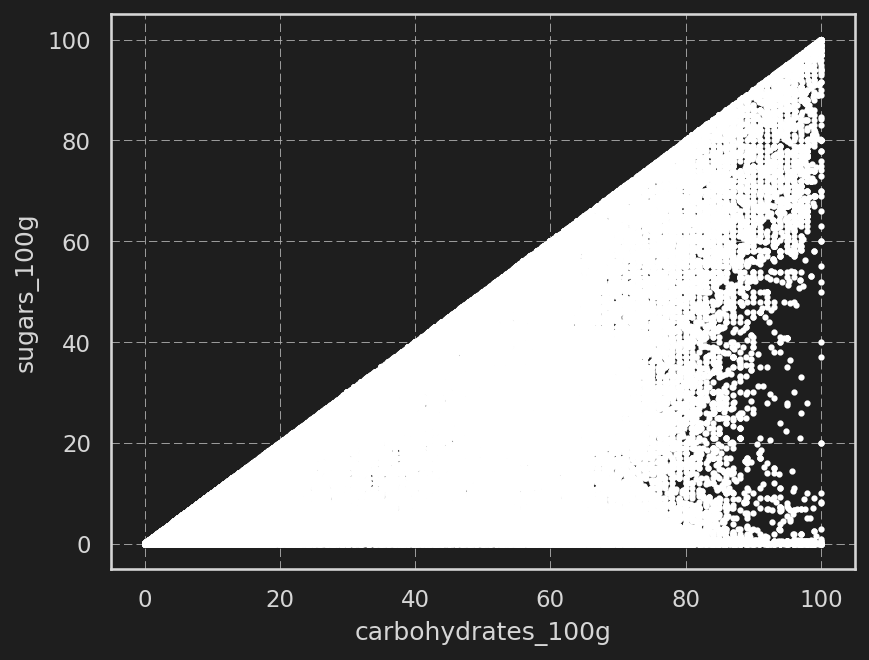

In [14]:
keys = data.keys()[ data.keys().str.contains('carbohydrates|sugar|glycemic|glucose|sucro|fructo|maltose|maltodextrin') ]
print( 'Keys linked to carbohydrates:', keys.tolist() )

print( 'len(data):', len(data) )
print( '\nSum ~ina:\n', (~data_isna[keys]).sum(0) )

df_croisement['carbohydrates'] = tools.croisement_NaN_counts( data_isna, keys )

print('Croisement NaN carbohydrates:')
display( df_croisement['carbohydrates'] )

print( 'Gestion valeurs abérrantes')

keys = data.keys()[ data.keys().str.contains('carbohydrates|sugar') ]
print( 'Keys linked to carbohydrates:', keys.tolist() )

# Remove values < 0 and values > 100
for key in keys:
    sr_loc = (data[key] < 0) | (data[key] > 100.)
    data.loc[ sr_loc , key] = np.nan
    data_isna.loc[ sr_loc, key ] = True

# remove values carbohydrates < surgars
sr_loc = (data['carbohydrates_100g'] < data['sugars_100g'])
data.loc[ sr_loc , keys ] = np.nan
data_isna.loc[ sr_loc, keys ] = True

# carbohydrates == 0 -> sugars = 0
data.loc[ data['carbohydrates_100g'] == 0. , 'sugars_100g' ] = 0.


# data_isna[keys] = data[keys].isna()
display( 'Sum ina:', data_isna[keys].sum(0) )

print('Croisement NaN carbohydrates:')
display( df_croisement['carbohydrates'] )

display('')

display( '~isna(carbo) & isna(sugar)', data.loc[ ~data_isna['carbohydrates_100g'] & data_isna['sugars_100g'] , [ 'product_name','carbohydrates_100g', 'sugars_100g', 'starch_100g']] )
display( 'isna(carbo) & ~isna(sugar)', data.loc[ data_isna['carbohydrates_100g'] & ~data_isna['sugars_100g'] , [ 'product_name','carbohydrates_100g', 'sugars_100g', 'starch_100g']] )

X, Y = 'carbohydrates_100g', 'sugars_100g'
fig, ax = plt.subplots()
ax.plot( data[X], data[Y], 'wo' , markersize=2 )
ax.set_xlabel(X)
ax.set_ylabel(Y)
del X, Y

## Energy
### Mise en évidence
- Vérification energy_100g == energy-kj_100g
- mise à Nan :
    * valeurs < 0
    * kJ > 3700
    * (kcal > 900)

1. Le tableau de contingences indique que la colonne `energy_100g` est la plus remplie, cependant les valeurs en `kcal` permettant de remplacer des NaN dans la colonne `energy_100g` ne semble pqs fiables
1. Les données `kj` et `energy` sont `égales` (quand energy-kj définie), mais les données en `kcal` ne sont pas toutes cohérentes: parfois elles sont `en kj`, d'autres fois `kcal` et `kj` sont `inversés`.
2. Certaines données se contre-disent (energy ~ 0 & kcal > 0)


In [15]:
X, Y = 'energy-kj_100g', 'energy_100g'
sr_loc = ~( data_isna[X] | data_isna[Y] )
print( '{:} rows are different ({:}, {:})'.format( (data.loc[sr_loc, X] != data.loc[sr_loc, Y]).sum(), X, Y ) )
# diff = data.loc[sr_loc, X] - data.loc[sr_loc, Y]
# print('diff: <{:.3f}>, std {:.3f}, max(abs()) {:.3f}'.format( diff.mean(), diff.std(), diff.abs().max() ) )

0 rows are different (energy-kj_100g, energy_100g)


'Keys linked to energy:'

['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g']

len(data): 313239

Sum ~ina:
energy-kj_100g           31273
energy-kcal_100g        239402
energy_100g             245903
energy-from-fat_100g        53
dtype: int64
Croisement NaN energy:


,isna(energy-kj_100g),isna(energy-kcal_100g),isna(energy_100g),isna(energy-from-fat_100g)
~isna(energy-kj_100g),0,8779,0,31272
~isna(energy-kcal_100g),216908,0,2326,239350
~isna(energy_100g),214630,8827,0,245850
~isna(energy-from-fat_100g),52,1,0,0


n ~(energy.isna | kcal.isna): (237076,)
n total (~energy.isna): 245903
n OK: 236101 (96.01%)
n kcal in kj: 11157 (4.54%)
n kcal in kj inverted: 10016 (4.07%)
n kcal > 4.5*kj: 30 (0.01%)


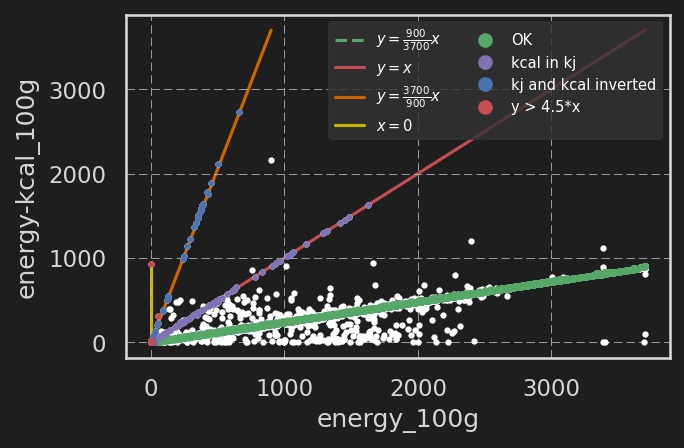

In [16]:
keys = data.keys()[ data.keys().str.contains('energy') ]
display( 'Keys linked to energy:', keys.tolist() )

for key in keys:
    sr_loc = (data[key] < 0.) | (data[key] > 3700.)
    data.loc[ sr_loc, key ] = np.nan
    data_isna.loc[ sr_loc, key ] = True

print( 'len(data):', len(data) )
print( '\nSum ~ina:')
print( (~data_isna[keys]).sum(0) )

df_croisement['energy'] = tools.croisement_NaN_counts( data_isna, keys )

print('Croisement NaN energy:')
display( df_croisement['energy'] )

wrong_1 = 'r'
wrong_2 = (0.8, 0.4, 0)
wrong_3 = (0.8, 0.7, 0)


def get_sub_sr_energy_management( x_kj, y_kcal ):
    """ get pd.Series for which energy seems : OK, kcal in kj, kcal and kj inverted, kcal > 4.5*kj """
    sr_1 = tools.distance_to_a_line( x_kj, y_kcal, 9/37, 0 )
    sr_2 = tools.distance_to_a_line( x_kj, y_kcal, 1., 0 )
    sr_3 = tools.distance_to_a_line( x_kj, y_kcal, 37/9, 0 )

    return sr_1 < 15**2, sr_2 < 15**2, sr_3 < 15**2, y > 4.5*x



X, Y = 'energy_100g', 'energy-kcal_100g'
sr_bool = ~(data_isna[X] | data_isna[Y])
x, y = data.loc[sr_bool,X], data.loc[sr_bool,Y]

sr_1, sr_2, sr_3, sr_4 = get_sub_sr_energy_management( x, y )

n_total = (~data_isna['energy_100g']).sum()
print('n ~(energy.isna | kcal.isna):', x.shape )
print('n total (~energy.isna):', n_total)
print('n OK: {:} ({:.2f}%)'.format( sr_1.sum(), sr_1.sum()/n_total*100 ) )
print('n kcal in kj: {:} ({:.2f}%)'.format(sr_2.sum(), sr_2.sum()/n_total*100) )
print('n kcal in kj inverted: {:} ({:.2f}%)'.format( sr_3.sum(), sr_3.sum()/n_total*100 ) )
print('n kcal > 4.5*kj: {:} ({:.2f}%)'.format( sr_4.sum(), sr_4.sum()/n_total*100 ) )

del n_total


# PLOT DATA
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )

ax.plot( x, y, 'wo', markersize=2)

ax.plot( [0, 3700], [0, 900], 'g--', zorder=2, label=r'$y = \frac{900}{3700} x$' )
ax.plot( [0, 3700], [0, 3700], color=wrong_1, zorder=0, label= r'$y = x$' )
ax.plot( [0, 900], [0, 3700], color=wrong_2, zorder=0, label= r'$y = \frac{3700}{900}x$' )
ax.plot( [0, 0], [0, 900], color=wrong_3, zorder=0, label= r'$x = 0$' )
# ax.legend()

ax.plot( x[sr_1], y[sr_1], 'go', markersize=2, label='OK')
ax.plot( x[sr_2], y[sr_2], 'mo', markersize=2, label='kcal in kj')
ax.plot( x[sr_3], y[sr_3], 'bo', markersize=2, label='kj and kcal inverted')
ax.plot( x[sr_4], y[sr_4], 'ro', markersize=2, label='y > 4.5*x')
lgnd = ax.legend( ncol=2, fontsize=7 )
for handle in lgnd.legendHandles:
    handle.set_markersize(6.0) # change markersize in legend

ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout( )


del sr_loc, sr_bool, sr_1, sr_2, sr_3, sr_4

if False: # 3d plot
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.plot( data['energy-kj_100g'], data['energy-kcal_100g'], data['energy_100g'], 'wo', markersize=2)
    ax.plot( [0,3700], [0,900], [0,3700], 'r--', label='coherent conversion' )
    ax.set_xlabel('energy-kj')
    ax.set_ylabel('energy-kcal')
    ax.set_zlabel('energy')
    ax.view_init( azim=10, elev=10 )
    ax.legend()

    ax = fig.add_subplot(122, projection='3d')
    ax.plot( data['energy-kj_100g'], data['energy-kcal_100g'], data['energy_100g'], 'wo', markersize=2)
    ax.plot( [0,3700], [0,900], [0,3700], 'r--', label='coherent conversion' )
    ax.set_xlabel('energy-kj')
    ax.set_ylabel('energy-kcal')
    ax.set_zlabel('energy')
    ax.view_init( azim=80, elev=30 )

    fig.tight_layout(pad=2)


### Rectification des données
Sachant que 1J = 4.184 calorie, parmis les variables "energy-kcal" et "energy" (kJ) la valeur la plus grande correspond (sauf erreur) à la valeur en kJ. La valeur conservée est donc la valeur maximale. Les valeurs en kcal sont enlevées.

<span style="color:red"> OLD </span>
À partir des courbes ci-dessus, les données en `kcal` exprimées en `kj` sont converties, et les données `inversées kcal <-> kj` sont re-inversées

In [17]:
if False:
    keys = data.keys()[ data.keys().str.contains('energy') ]
    display( 'Keys linked to energy:', keys.tolist() )


    ikeys = { key: data.columns.get_loc(key) for key in data.keys() }

    # Modification energy < 4.5 * energy-kcal
    X, Y = 'energy_100g', 'energy-kcal_100g'
    # get sr to non NaN values and for whch kcal > 4.5 * energy (kj)
    sr_loc = ~( data_isna[X] | data_isna[Y]) 
    sr_loc = ( data.loc[sr_loc, X] < 4.5*data.loc[sr_loc,Y] )
    sr_iloc = sr_loc[sr_loc].index

    x, y = data.iloc[sr_iloc, ikeys[X]].copy(), data.iloc[sr_iloc, ikeys[Y]].copy()

    print('energy:', data['energy_100g'][sr_iloc].values[0:3])
    print('energy kj:', data['energy-kj_100g'][sr_iloc].values[0:3])
    print('energy kcal:', data['energy-kcal_100g'][sr_iloc].values[0:3])

    indexes_1, indexes_2, indexes_3, indexes_4 = get_sub_indexes_energy_management( x, y )
    y[indexes_2] *= (9./37.)
    x[indexes_3], y[indexes_3] = y[indexes_3].copy(), x[indexes_3].copy()


    # sr_tmp = (y != data[Y][sr_iloc]).index
    # print('\ny != data[Y] (index):', sr_tmp )

    # y.iloc[0] = 10000

    print('\nx:', x.values[0:3])
    print('y:', y.values[0:3])

    data.iloc[ sr_iloc , ikeys['energy_100g']] = x.copy()
    data.iloc[ sr_iloc , ikeys['energy-kj_100g']] = x.copy()
    data.iloc[ sr_iloc , ikeys['energy-kcal_100g']] = y.copy()


    print('\nenergy:', data['energy_100g'][sr_iloc].values[0:3])
    print('energy kj:', data['energy-kj_100g'][sr_iloc].values[0:3])
    print('energy kcal:', data['energy-kcal_100g'][sr_iloc].values[0:3])


if False:
    X, Y = 'energy_100g', 'energy-kcal_100g'
    sr_bool = ~(data_isna[X] | data_isna[Y])
    sr_iloc = sr_bool[sr_bool].index
    x, y = data.iloc[sr_iloc,ikeys[X]], data.iloc[sr_iloc,ikeys[Y]]

    indexes_1, indexes_2, indexes_3, indexes_4 = get_sub_indexes_energy_management( x, y )
    # Apply modification locally to check
    y[indexes_2] *= (9./37.)
    x[indexes_3], y[indexes_3] = y[indexes_3].copy(), x[indexes_3].copy()

    print('\n\nx:', x[indexes_4].values[0:3] )
    print('y:', y[indexes_4].values[0:3] )


In [18]:
if False:
    keys = data.keys()[ data.keys().str.contains('energy') ]
    display( 'Keys linked to energy:', keys.tolist() )



    # Modification energy
    X, Y = 'energy_100g', 'energy-kcal_100g'
    # get sr to non NaN values and for whch kcal > 4.5 * energy (kj)
    sr_loc = ~( data_isna[X] | data_isna[Y])
    sr_loc[sr_loc] = sr_loc[sr_loc] & ( data.loc[sr_loc, X] < 4.5*data.loc[sr_loc,Y] )

    x, y = data.loc[sr_loc, X].copy(), data.loc[sr_loc, Y].copy()

    print('energy:', data.loc[sr_loc,'energy_100g'].values[0:3])
    print('energy kj:', data.loc[sr_loc,'energy-kj_100g'].values[0:3])
    print('energy kcal:', data.loc[sr_loc,'energy-kcal_100g'].values[0:3])

    indexes_1, indexes_2, indexes_3, indexes_4 = get_sub_indexes_energy_management( x, y )
    y[indexes_2] *= (9./37.)
    x[indexes_3], y[indexes_3] = y[indexes_3].copy(), x[indexes_3].copy()


    # y.iloc[0] = 10000
    # print('\nx:', x.values[0:3])
    # print('y:', y.values[0:3])

    data.loc[ sr_loc , 'energy_100g'] = x.copy()
    data.loc[ sr_loc , 'energy-kj_100g'] = x.copy()
    data.loc[ sr_loc , 'energy-kcal_100g'] = y.copy()


    print('\nenergy:', data['energy_100g'][sr_loc].values[0:3])
    print('energy kj:', data['energy-kj_100g'][sr_loc].values[0:3])
    print('energy kcal:', data['energy-kcal_100g'][sr_loc].values[0:3])



if False:
    X, Y = 'energy_100g', 'energy-kcal_100g'
    sr_bool = ~(data_isna[X] | data_isna[Y])
    x, y = data.loc[sr_loc, X], data.loc[sr_loc, Y]

    indexes_1, indexes_2, indexes_3, indexes_4 = get_sub_indexes_energy_management( x, y )
    # Apply modification locally to check
    y[indexes_2] *= (9./37.)
    x[indexes_3], y[indexes_3] = y[indexes_3].copy(), x[indexes_3].copy()

    print('\n\nx:', x[indexes_4].values[0:3] )
    print('y:', y[indexes_4].values[0:3] )


In [19]:
keys = data.keys()[ data.keys().str.contains('energy') ]

sr_loc = ~(data_isna['energy_100g'])
data.loc[ sr_loc, 'energy_100g' ] = data.loc[ sr_loc, 
                                        ['energy_100g', 'energy-kcal_100g']
                                        ].fillna( 0. ).max(1)

data['energy-kj_100g'] = data['energy_100g'].copy()
data_isna['energy-kj_100g'] = data_isna['energy_100g'].copy()

if False:
    # Modification energy
    X, Y = 'energy_100g', 'energy-kcal_100g'
    # get sr to non NaN values
    sr_loc = ~( data_isna[X] | data_isna[Y])
    # sr_loc[sr_loc] = sr_loc[sr_loc] & ( data.loc[sr_loc, X] < 4.5*data.loc[sr_loc,Y] )

    x, y = data.loc[sr_loc, X].copy(), data.loc[sr_loc, Y].copy()

    sr_1, sr_2, sr_3, sr_4 = get_sub_sr_energy_management( x, y )
    x_ok, y_ok = x[sr_1].copy(), y[sr_1].copy()
    y[sr_2] *= (9./37.)
    x[sr_3], y[sr_3] = y[sr_3].copy(), x[sr_3].copy()
    x[sr_1], y[sr_1] = x_ok, y_ok # The data overlap due to margins

    del sr_1, sr_2, sr_3, sr_4

    data.loc[ sr_loc , 'energy_100g'] = x.copy()
    data.loc[ sr_loc , 'energy-kj_100g'] = x.copy()
    data.loc[ sr_loc , 'energy-kcal_100g'] = y.copy()

    data['energy-kj_100g'] = data['energy_100g'].copy()
    data_isna['energy-kj_100g'] = data_isna['energy_100g'].copy()

'Keys linked to energy:'

['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g']

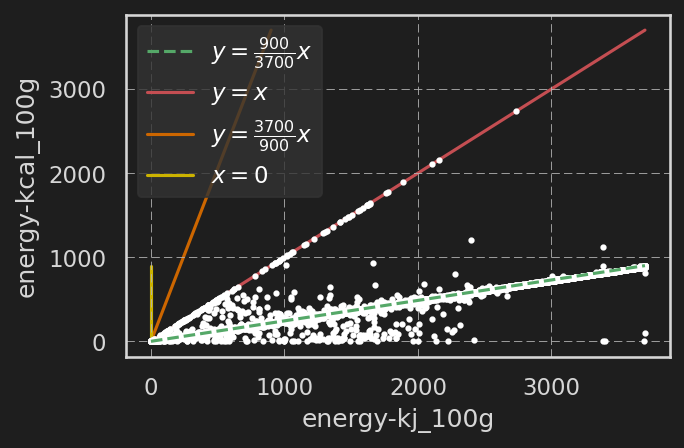

In [20]:
keys = data.keys()[ data.keys().str.contains('energy') ]
display( 'Keys linked to energy:', keys.tolist() )


wrong_1 = 'r'
wrong_2 = (0.8, 0.4, 0)
wrong_3 = (0.8, 0.7, 0)


X, Y = 'energy-kj_100g', 'energy-kcal_100g'
sr_loc = ~(data_isna[X] | data_isna[Y])
x, y = data.loc[sr_loc, X], data.loc[sr_loc, Y]
# sr_1, sr_2, sr_3, sr_4 = get_sub_sr_energy_management( x, y )


fig, ax = plt.subplots( figsize=(12*cm,8*cm) )

ax.plot( x, y, 'wo', markersize=2)
ax.plot( [0, 3700], [0, 900], 'g--', zorder=2, label=r'$y = \frac{900}{3700} x$' )
ax.plot( [0, 3700], [0, 3700], color=wrong_1, zorder=0, label= r'$y = x$' )
ax.plot( [0, 900], [0, 3700], color=wrong_2, zorder=0, label= r'$y = \frac{3700}{900}x$' )
ax.plot( [0, 0], [0, 900], color=wrong_3, zorder=0, label= r'$x = 0$' )
ax.legend()

# ax.plot( x[sr_1], y[sr_1], 'go', markersize=2, label='OK')
# ax.plot( x[sr_2], y[sr_2], 'mo', markersize=2, label='kcal in kj')
# ax.plot( x[sr_3], y[sr_3], 'bo', markersize=2, label='kj and kcal inverted')
# ax.plot( x[sr_4], y[sr_4], 'ro', markersize=2, label='y > 4.5*x')
# lgnd = ax.legend( ncol=2, fontsize=7 )
# for handle in lgnd.legendHandles:
#     handle.set_markersize(6.0) # change markersize in legend

ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout( )




del sr_loc

if False: # 3d plot
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.plot( data['energy-kj_100g'], data['energy-kcal_100g'], data['energy_100g'], 'wo', markersize=2)
    ax.plot( [0,3700], [0,900], [0,3700], 'r--', label='coherent conversion' )
    ax.set_xlabel('energy-kj')
    ax.set_ylabel('energy-kcal')
    ax.set_zlabel('energy')
    ax.view_init( azim=10, elev=10 )
    ax.legend()

    ax = fig.add_subplot(122, projection='3d')
    ax.plot( data['energy-kj_100g'], data['energy-kcal_100g'], data['energy_100g'], 'wo', markersize=2)
    ax.plot( [0,3700], [0,900], [0,3700], 'r--', label='coherent conversion' )
    ax.set_xlabel('energy-kj')
    ax.set_ylabel('energy-kcal')
    ax.set_zlabel('energy')
    ax.view_init( azim=80, elev=30 )

    fig.tight_layout(pad=2)


In [21]:
data.drop( columns=['energy-kcal_100g', 'energy_100g'] , inplace=True)
data_isna.drop( columns=['energy-kcal_100g', 'energy_100g'] , inplace=True)
print( 'keys:', data.keys().tolist() )

keys: ['level_0', 'index', 'code', 'last_modified_t', 'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'ecoscore_score_fr', 'ecoscore_grade_fr', 'energy-kj_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-

## Fiber
- Mise à NaN valeurs < 0 | > 100
- les colonnes `soluble` et `insolubles` sont clairement inutilisables (trop peu d'élements non NaN)

In [22]:
keys = data.keys()[ data.keys().str.contains('fiber') ]
display( 'Keys linked to fiber:', keys.tolist() )

for key in keys:
    sr_loc = (data[key] < 0.) | (data[key] > 100.)
    data.loc[ sr_loc, key ] = np.nan
    data_isna.loc[ sr_loc, key ] = True

display( 'len(data):', len(data) )
display( 'Sum ~ina:', (~data_isna[keys]).sum(0) )
df_croisement['fiber'] = tools.croisement_NaN_counts( data_isna, keys )

print('Croisement NaN fiber:')
display( df_croisement['fiber'] )


'Keys linked to fiber:'

['fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g']

'len(data):'

313239

'Sum ~ina:'

fiber_100g              60890
soluble-fiber_100g         62
insoluble-fiber_100g       55
dtype: int64

Croisement NaN fiber:


,isna(fiber_100g),isna(soluble-fiber_100g),isna(insoluble-fiber_100g)
~isna(fiber_100g),0,60828,60835
~isna(soluble-fiber_100g),0,0,14
~isna(insoluble-fiber_100g),0,7,0


## Salt / Sodium

In [23]:
keys = data.keys()[ data.keys().str.contains('salt|sodium') ]
display( 'Keys linked to salt:', keys.tolist() )

for key in keys:
    sr_loc = (data[key] < 0.) | (data[key] > 100.)
    data.loc[ sr_loc, key ] = np.nan
    data_isna.loc[ sr_loc, key ] = True

display( 'len(data):', len(data) )
display( 'Sum ~ina:', (~data_isna[keys]).sum(0) )
df_croisement['salt'] = tools.croisement_NaN_counts( data_isna, keys )

print('Croisement NaN salt:')
display( df_croisement['salt'] )

'Keys linked to salt:'

['salt_100g', 'sodium_100g']

'len(data):'

313239

'Sum ~ina:'

salt_100g      237607
sodium_100g    237617
dtype: int64

Croisement NaN salt:


,isna(salt_100g),isna(sodium_100g)
~isna(salt_100g),0,0
~isna(sodium_100g),10,0


## Fat

In [24]:
keys = data.keys()[ data.keys().str.contains('fat') & ~data.keys().str.contains('energy') ]
display( 'Keys linked to fat:', keys.tolist() )

# set rows to NaN if fat_100g is not the maximum value
sr_loc = data[keys].fillna(0.).idxmax( 1 ) != 'fat_100g'

data.loc[ sr_loc, keys ] = np.nan
data_isna.loc[ sr_loc, keys ] = True

print('Number of remove data on fats: {:} / {:}'.format( sr_loc.sum(), len(sr_loc) ) )

'Keys linked to fat:'

['fat_100g',
 'saturated-fat_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'omega-6-fat_100g',
 'omega-9-fat_100g',
 'trans-fat_100g']

Number of remove data on fats: 854 / 313239


In [25]:
keys = data.keys()[ data.keys().str.contains('fat') & ~data.keys().str.contains('energy') ]
display( 'Keys linked to fat:', keys.tolist() )

for key in keys:
    sr_loc = (data[key] < 0.) | (data[key] > 100.)
    data.loc[ sr_loc, key ] = np.nan
    data_isna.loc[ sr_loc, key ] = True


display( 'len(data):', len(data) )
display( 'Sum ~ina:', (~data_isna[keys]).sum(0) )
df_croisement['fat'] = tools.croisement_NaN_counts( data_isna, keys )

print('Croisement NaN fat:')
display( df_croisement['fat'] )

'Keys linked to fat:'

['fat_100g',
 'saturated-fat_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'omega-6-fat_100g',
 'omega-9-fat_100g',
 'trans-fat_100g']

'len(data):'

313239

'Sum ~ina:'

fat_100g                    245933
saturated-fat_100g          246850
monounsaturated-fat_100g      1181
polyunsaturated-fat_100g      1191
omega-3-fat_100g               502
omega-6-fat_100g               100
omega-9-fat_100g                16
trans-fat_100g                1321
dtype: int64

Croisement NaN fat:


,isna(fat_100g),isna(saturated-fat_100g),isna(monounsaturated-fat_100g),isna(polyunsaturated-fat_100g),isna(omega-3-fat_100g),isna(omega-6-fat_100g),isna(omega-9-fat_100g),isna(trans-fat_100g)
~isna(fat_100g),0,1136,244753,244743,245431,245833,245917,244613
~isna(saturated-fat_100g),2053,0,245671,245660,246349,246751,246834,245530
~isna(monounsaturated-fat_100g),1,2,0,26,1007,1115,1174,846
~isna(polyunsaturated-fat_100g),1,1,36,0,1002,1124,1184,860
~isna(omega-3-fat_100g),0,1,328,313,0,416,493,487
~isna(omega-6-fat_100g),0,1,34,33,14,0,89,88
~isna(omega-9-fat_100g),0,0,9,9,7,5,0,16
~isna(trans-fat_100g),1,1,986,990,1306,1309,1321,0


## Décompte et drop des colonnes inutiles

In [26]:
sr_sum_not_isna = (~data_isna).sum(0).sort_values()
sr_drop = sr_sum_not_isna[ (sr_sum_not_isna < 0.1*len(data)) & ~(sr_sum_not_isna.index == 'index') & ~(sr_sum_not_isna.index.str.contains('level_0')) ].index
display( sr_drop )
with pd.option_context('display.max_rows', None):
    display( sr_sum_not_isna )
data.drop( columns=sr_drop , inplace=True )
data_isna.drop( columns=sr_drop , inplace=True )
del sr_sum_not_isna, sr_drop

Index(['-alpha-linolenic-acid_100g', '-melissic-acid_100g',
       '-montanic-acid_100g', '-cerotic-acid_100g', '-lignoceric-acid_100g',
       '-behenic-acid_100g', '-arachidic-acid_100g', '-stearic-acid_100g',
       '-palmitic-acid_100g', '-myristic-acid_100g',
       ...
       'ingredients_that_may_be_from_palm_oil_tags', 'origins_en',
       'origins_tags', 'origins', 'traces', 'manufacturing_places_tags',
       'manufacturing_places', 'traces_tags', 'traces_en', 'generic_name'],
      dtype='object', length=116)

index                                                   -125324895668
level_0                                                  -50367986135
-alpha-linolenic-acid_100g                                          0
-melissic-acid_100g                                                 0
-montanic-acid_100g                                                 0
-cerotic-acid_100g                                                  0
-lignoceric-acid_100g                                               0
-behenic-acid_100g                                                  0
-arachidic-acid_100g                                                0
-stearic-acid_100g                                                  0
-palmitic-acid_100g                                                 0
-myristic-acid_100g                                                 0
-lauric-acid_100g                                                   0
-capric-acid_100g                                                   0
-caprylic-acid_100g 

# SAVE DATA

In [27]:
display(data.keys())

Index(['level_0', 'index', 'code', 'last_modified_t', 'last_modified_datetime',
       'product_name', 'quantity', 'labels', 'labels_tags', 'labels_en',
       'ingredients_text', 'allergens', 'additives_n', 'additives_tags',
       'additives_en', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'ecoscore_score_fr', 'ecoscore_grade_fr', 'energy-kj_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

In [28]:
lst_to_drop = [ 'level_0', 'index', 'last_modified_t', 'last_modified_datetime',
                'nutrition-score-fr_100g' , 'labels', 'labels_tags',
                'additives_tags', 'additives_en', 
                'ecoscore_score_fr', 'ecoscore_grade_fr',
                ]

data['pnns_groups_1'] = data['pnns_groups_1'].astype('category')
# data['pnns_groups_1_code'] = data['pnns_groups_1'].cat.codes

data['nutriscore_grade'] = data['nutriscore_grade'].astype('category')

data.drop( columns=lst_to_drop ).to_pickle( 'data_clean.pkl')

***
# SUITE

## Remove empty and some usused/unusable columns

'Keys linked to nutriscore:'

['nutriscore_score',
 'nutriscore_grade',
 'nova_group',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

In [8]:
n_null_lim_drop = int(0.7*n)

categories_full = sum_isnull[ sum_isnull == 0].index.to_list()
print('\nFull categories:', categories_full)

categories_hollow = sum_isnull[ sum_isnull > n_null_lim_drop].index.to_list()
print('\nHollow categories:', categories_hollow)

# drop caterories to keep (with keep_keys)
removed_cat = pd.Series( categories_hollow )
removed_cat = removed_cat[ ~removed_cat.str.contains(keep_keys) ].to_list()

# check is completely empty categories remains
removed_cat += [ key for key in sum_isnull[ sum_isnull == n].index if not key in removed_cat ]

# check for dupplicated entry and if key are still in DataFrame
removed_cat = [ key for i, key in enumerate( removed_cat ) if (not key in removed_cat[:i]) and (key in data.keys()) ]

print('\nRemoved categories:' )
if False: # vertical display
    display( pd.DataFrame( {'categorie': [key for key in removed_cat] ,
                            'n null': [sum_isnull[key] for key in removed_cat] } ) )
else: # horizontal display
    display( pd.DataFrame( { key:[np.round( sum_isnull[key]/n*100, 2)] for key in removed_cat } , index=['% isnull'] ) )

# print('')
# data.memory_usage()

if True: data.drop( columns=removed_cat, inplace=True )
# if True: data = data.drop( columns=removed_cat )

# print('')
# data.memory_usage()

# msno.bar( data )


Full categories: ['code', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'states', 'states_tags', 'states_en']

Hollow categories: ['quantity', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'brand_owner', 'ecoscore_score_fr', 'ecoscore_grade_fr', 'energy-kj_100g', 'energy-from-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-ac

,quantity,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,emb_codes,emb_codes_tags,cities,cities_tags,purchase_places,stores,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives,additives_tags,additives_en,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,energy-kj_100g,energy-from-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,casein_100g,serum-proteins_100g,nucleotides_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
% isnull,74.45,95.73,95.74,95.74,93.86,93.86,94.12,94.12,100.0,96.26,92.42,86.73,90.91,100.0,95.0,93.83,93.83,76.08,76.26,100.0,100.0,80.27,80.27,100.0,99.33,100.0,97.98,86.72,76.71,76.71,92.74,99.95,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,97.78,97.78,99.9,100.0,100.0,100.0,99.97,100.0,100.0,100.0,100.0,99.99,100.0,100.0,100.0,100.0,100.0,100.0,87.88,87.69,100.0,100.0,100.0,100.0,100.0,100.0,99.97,99.83,72.56,99.84,99.85,100.0,99.99,100.0,98.88,90.26,100.0,99.53,99.83,99.94,89.91,98.9,98.95,98.9,99.26,99.51,99.61,99.4,99.94,99.71,99.99,99.98,95.77,99.96,87.6,99.36,87.87,99.33,99.53,99.8,99.82,99.98,99.88,99.99,99.98,99.89,99.97,99.99,99.99,99.55,99.96,99.45,99.99,99.7,100.0,99.98,99.45,100.0,100.0,100.0,100.0,99.92,100.0,100.0,100.0


## Visualisation of NaN for new DataFrame

In [9]:
print(sum_isnull.size, len(categories), len(data.keys()))
with pd.option_context('display.max_rows', None):
    print( sum_isnull[data.keys()].sort_values() )
msno.bar( data )

175 175 44
code                                                          0
created_t                                                     0
created_datetime                                              0
last_modified_t                                               0
last_modified_datetime                                        0
states_tags                                                   0
states                                                        0
states_en                                                     0
creator                                                       1
pnns_groups_2                                               108
pnns_groups_1                                               108
countries                                                  2300
countries_tags                                             2301
countries_en                                               2301
product_name                                              31080
energy_100g                  

## Check dtypes

In [11]:
with pd.option_context('display.max_rows', None):
    display(data.dtypes)

code                                                       object
creator                                                    object
created_t                                                   int64
created_datetime                                           object
last_modified_t                                             int64
last_modified_datetime                                     object
product_name                                               object
categories                                                 object
categories_tags                                            object
categories_en                                              object
labels                                                     object
labels_tags                                                object
labels_en                                                  object
countries                                                  object
countries_tags                                             object
countries_

## Création de listes des catégories: string / float64 / others

In [12]:
categories_float, categories_others = [], []
for cat in data.keys():
    if data.dtypes[cat] == 'float64': categories_float.append( cat )
    else: categories_others.append( cat )
# ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )
categories_string = []
# print('\nstrings to lowercase')
for key in categories_others: 
    # print(key, 'type', data[key].dtype)
    if data[key].dtype != 'object': continue
    categories_string.append( key )
    # data[key].str.lower()

categories_others = [key for key in categories_others if not key in categories_string]
print("float categories:", categories_float )
print("\nstring categories:", categories_string )
print("\nothers categories:", categories_others )


float categories: ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']

string categories: ['code', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'categories', 'categories_tags', 'categories_en', 'labels', 'labels_tags', 'labels_en', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'states', 'states_tags', 'states_en', 'main_category', 'main_category_en']

others categories: ['created_t', 'last_modified_t', 'nutriscore_grade', 'nova_group']


## Pré-traitement des variables `"category"`
1. rename_categories 
    - nitriscore_grade $\rightarrow$ upper
    - nova_group $\rightarrow$ int
1. String columns $\rightarrow$ str.lower
1. `'pnn_groups'` et `'food_groups'`: `unknown` $\rightarrow$ `NaN`  
1. food_groups: `'en:'` $\rightarrow$ `''`,  `'-'` $\rightarrow$ `' '`(for readability)
1. print first values for each category

In [13]:
string_catergories_to_value_count = ['nova_group', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'food_groups']

# Modification of categories (nitriscore_grade -> upper, nova_group -> int)
data['nutriscore_grade'] = data['nutriscore_grade'].cat.rename_categories( {cat:cat.upper() for cat in data['nutriscore_grade'].cat.categories} )
data['nova_group'] = data['nova_group'].cat.rename_categories( {cat:int(float(cat)) for cat in data['nova_group'].cat.categories} )


# lower all string
for key in string_catergories_to_value_count:
    print('\n', key, data[key].dtype.kind)
    # if data[key].dtype.kind != 'O': continue # Check if dtyp is object
    # if not pd.api.types.is_string_dtype( data[key].dtype ): continue
    if data[key].dtype != 'object': continue
    data[key] = data[key].str.lower()


# replace "en:" and "-" in food_groups to improve readability
data['food_groups'] = data['food_groups'].str.replace( 'en:' , '' , regex=False )
data['food_groups'] = data['food_groups'].str.replace( '-', ' ' , regex=False )


# replace 'unknown' to NaN
data.replace( {'pnns_groups_1':'unknown',
                'pnns_groups_2':'unknown',
                'food_groups':'unknown'}, np.nan, inplace=True )
# data.replace( { 'pnns_groups_1':{'unknown':np.nan},
#                 'pnns_groups_2':{'unknown':np.nan} }, inplace=True )



# astype category
# data[string_catergories_to_value_count] = data[string_catergories_to_value_count].astype('category')

for key in string_catergories_to_value_count:
    print('\n', key, data.dtypes[key])
    i = 0
    for value in data[key] :
        if pd.isnull( value ) : continue
        print(value )
        i += 1
        if i == 10: break


 nova_group O

 nutriscore_grade O

 pnns_groups_1 O

 pnns_groups_2 O

 food_groups O

 nova_group category
3
4
3
3
3
4
4
1
1
4

 nutriscore_grade category
D
E
D
A
D
B
B
B
A
D

 pnns_groups_1 object
beverages
milk and dairy products
beverages
fish meat eggs
fish meat eggs
milk and dairy products
fat and sauces
beverages
fish meat eggs
fish meat eggs

 pnns_groups_2 object
teas and herbal teas and coffees
dairy desserts
waters and flavored waters
fish and seafood
meat
cheese
dressings and sauces
fruit juices
meat
meat

 food_groups object
teas and herbal teas and coffees
dairy desserts
waters and flavored waters
fish and seafood
poultry
cheese
dressings and sauces
unsweetened beverages
poultry
poultry


## Calcul et affichage: value_counts des varialbes category

,nova_group,nutriscore_grade,pnns_groups_1,pnns_groups_2,food_groups
0,4,5,10,40,45


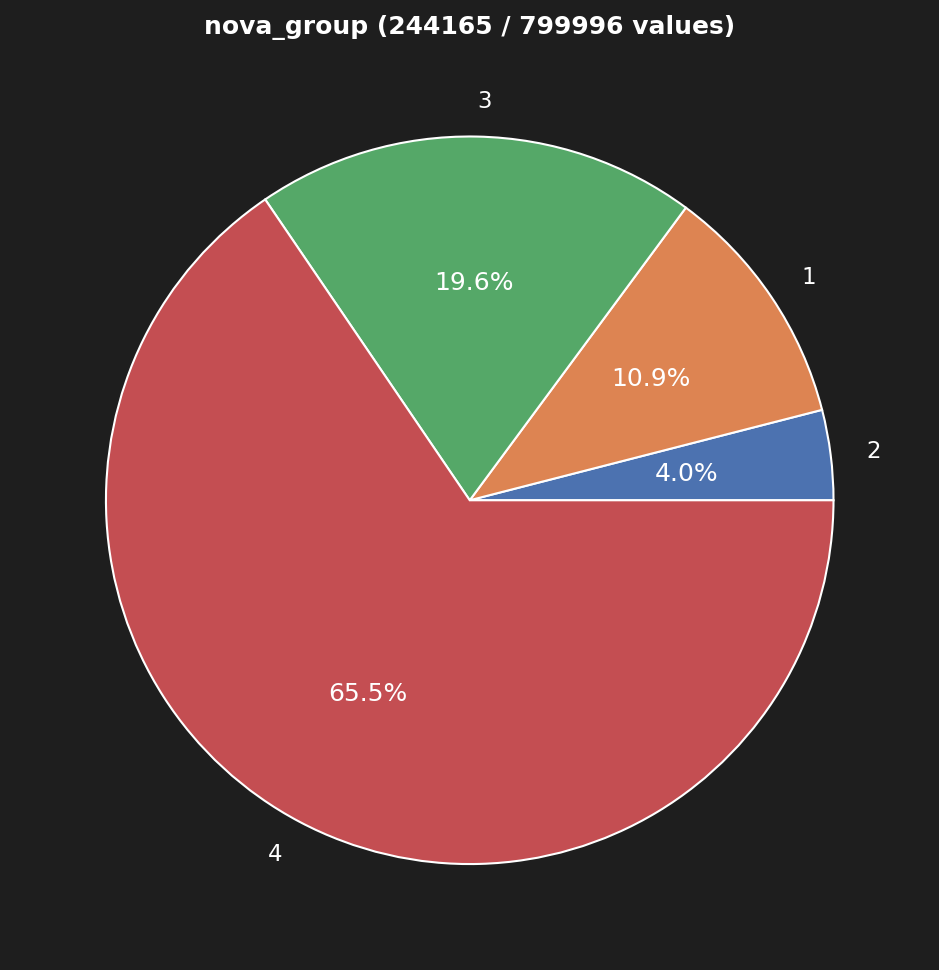

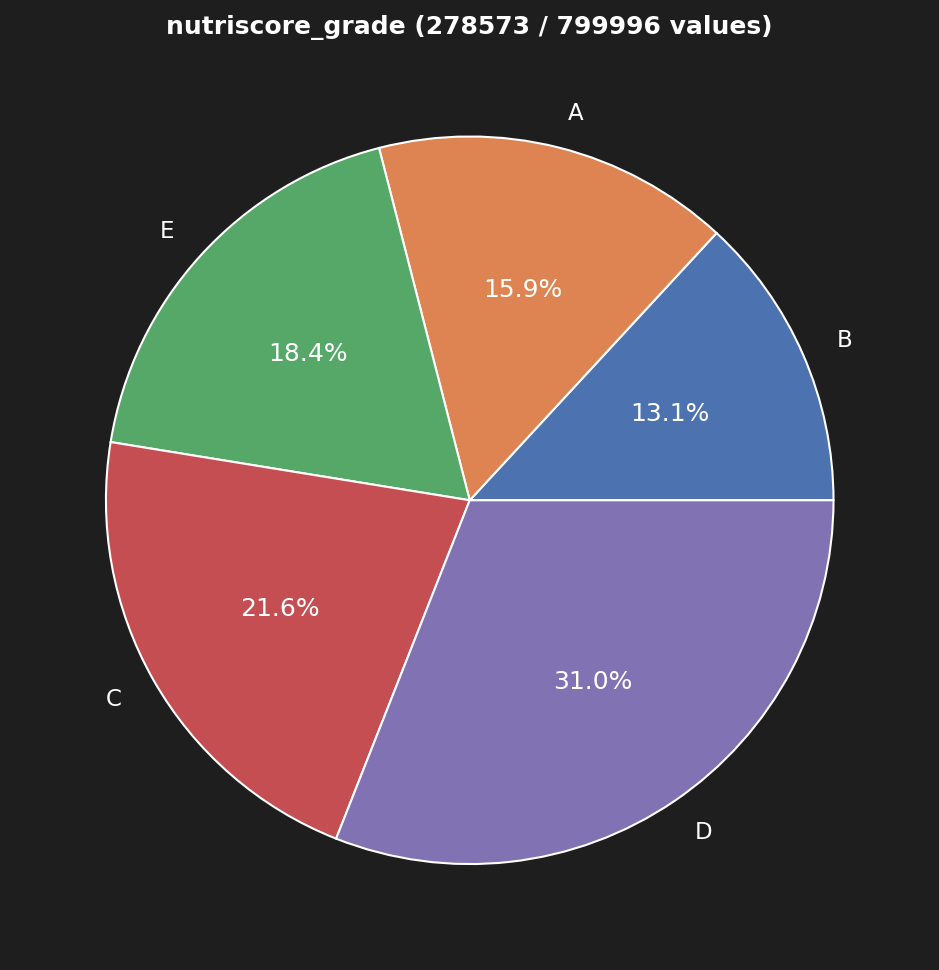

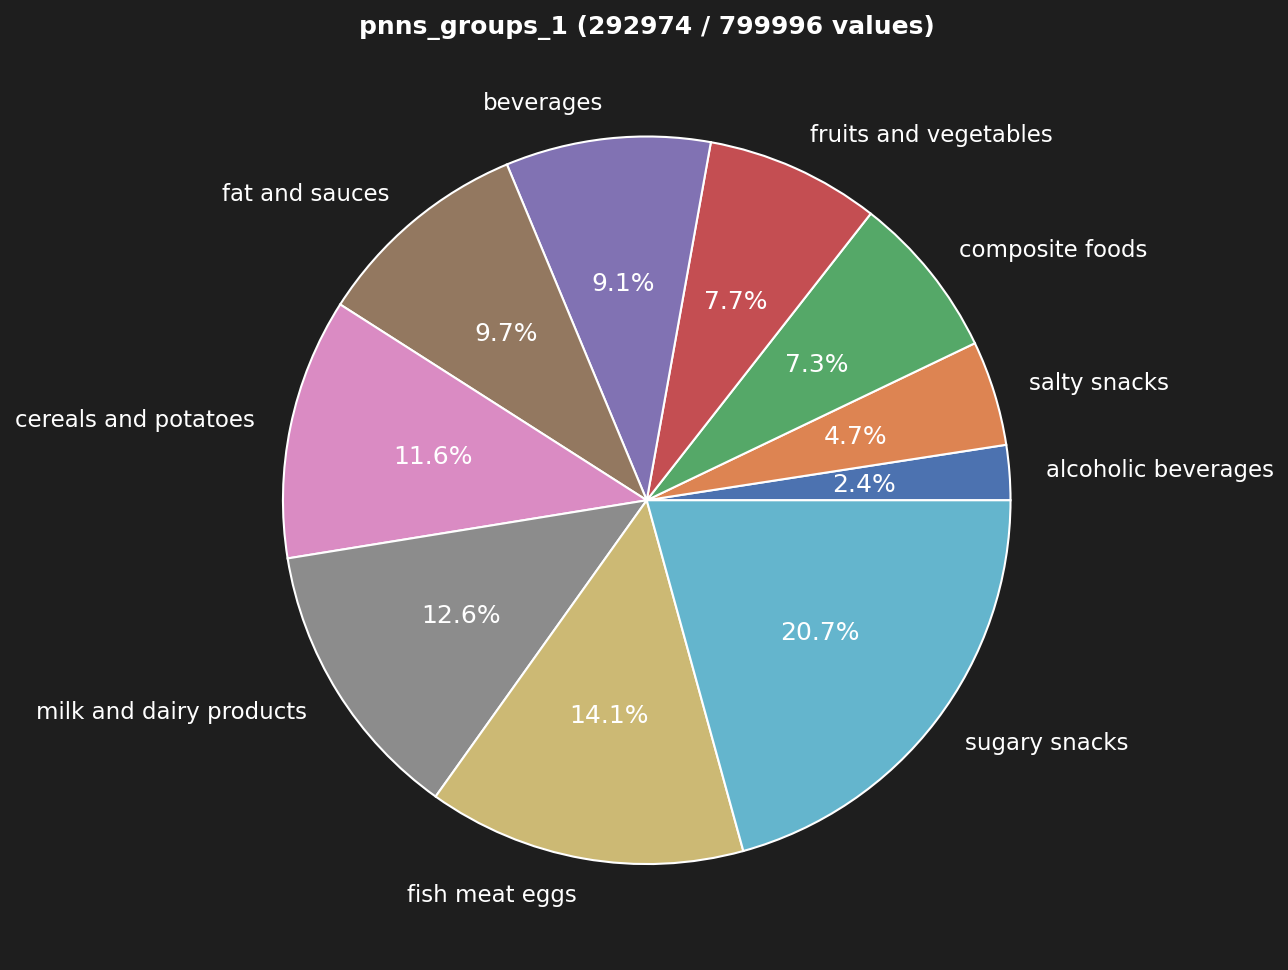

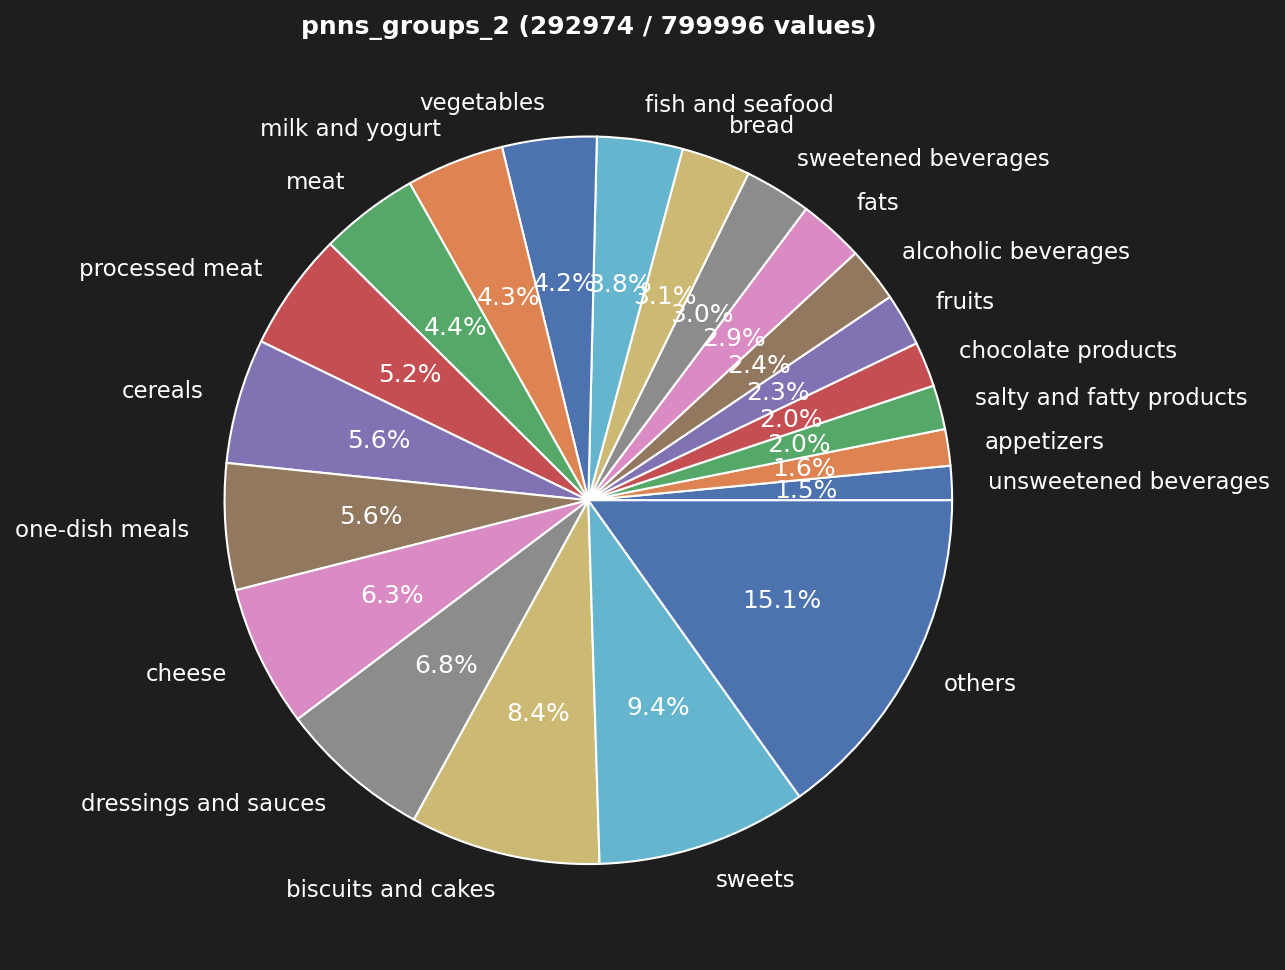

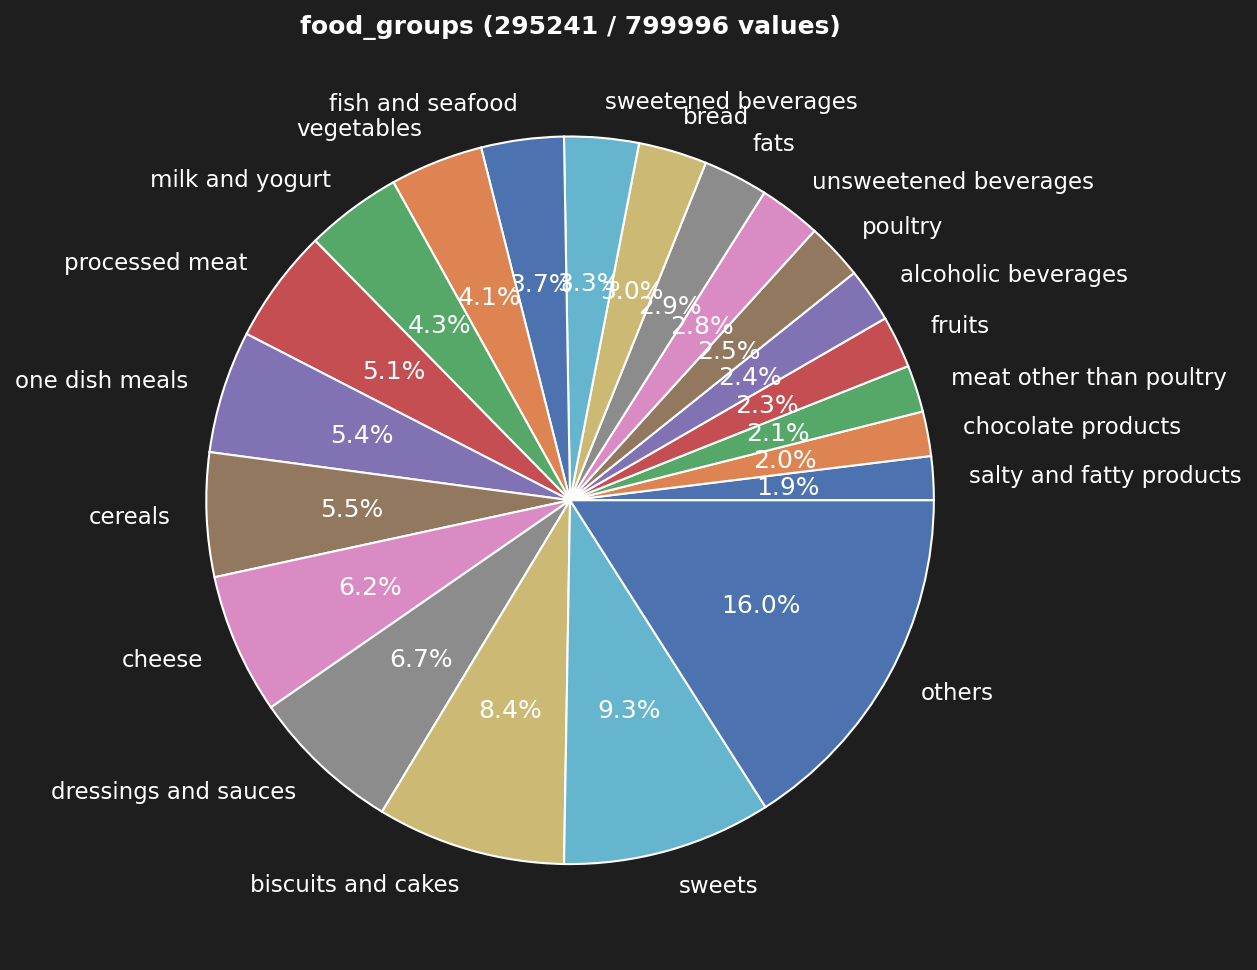

In [14]:
dico_value_counts = { key: data[key].value_counts().sort_values() for key in string_catergories_to_value_count }
data_value_counts = pd.DataFrame( {key:[len(dico_value_counts[key])] for key in string_catergories_to_value_count} )
display(data_value_counts)
# data_value_counts.plot( kind='bar' )

# print('min counts', data_value_counts.iloc[0,:].min() )

n_lim_categories = 20
for key in string_catergories_to_value_count:
    sr_plot = dico_value_counts[key]
    n_sum = sr_plot.sum()

    if dico_value_counts[key].size > n_lim_categories:
        sr_plot = sr_plot.sort_values( ascending=False )
        sr_plot = pd.concat( [sr_plot[:n_lim_categories], 
                                pd.Series( [sr_plot[n_lim_categories:].sum()] , index=['others'] ),
                             ] )
        

    fig, ax = plt.subplots( figsize=(20*cm,20*cm))
    # pd.Series( sr_plot.sort_index( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    pd.Series( sr_plot.sort_values( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    ax.set_title( '{:} ({:} / {:} values)'.format( key, n_sum, n), weight='bold')
    ax.set_ylabel('')

    # fig, ax = plt.subplots( figsize=(20*cm, 10*cm*(data_value_counts[key][0]/10)) )
    # pd.Series( dico_value_counts[key] ).plot( kind='barh' , ax=ax )
    # ax.set_title(key)

if False: # barplot
    cat_pos = np.arange( len(string_catergories_to_value_count) )
    print(cat_pos)
    fig, ax = plt.subplots( figsize=(20*cm,10*cm))
    if True: # horizontal
        ax.bar( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_xticks(cat_pos, labels=string_catergories_to_value_count)
    else:
        ax.barh( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_yticks(cat_pos, labels=string_catergories_to_value_count)
        ax.invert_yaxis()  # labels read top-to-bottom

    fig.tight_layout()
    del cat_pos


## Comparaison pnns_groups_1/_2 et food_groups: tableaux de contingences
L'objectif est de vérifier si il est possible et utile de remplir la variable 'pnns_groups_1' à partir de 'pnns_groups_2' ou 'food_groups'

1. Copie des données pour pnns_groups et food_groups
1. msno heatmap $\rightarrow$ vérification de la corrélation entre les NaN des différentes variables
1. Drop des lignes avec au moin un NaN
1. Calcul et affichage d'une image type tableau de contingence

nan in data_chi:
pnns_groups_1    505679
pnns_groups_2    507982
food_groups      505717
dtype: int64

nan in data_chi:
pnns_groups_1    0
pnns_groups_2    0
food_groups      0
dtype: int64


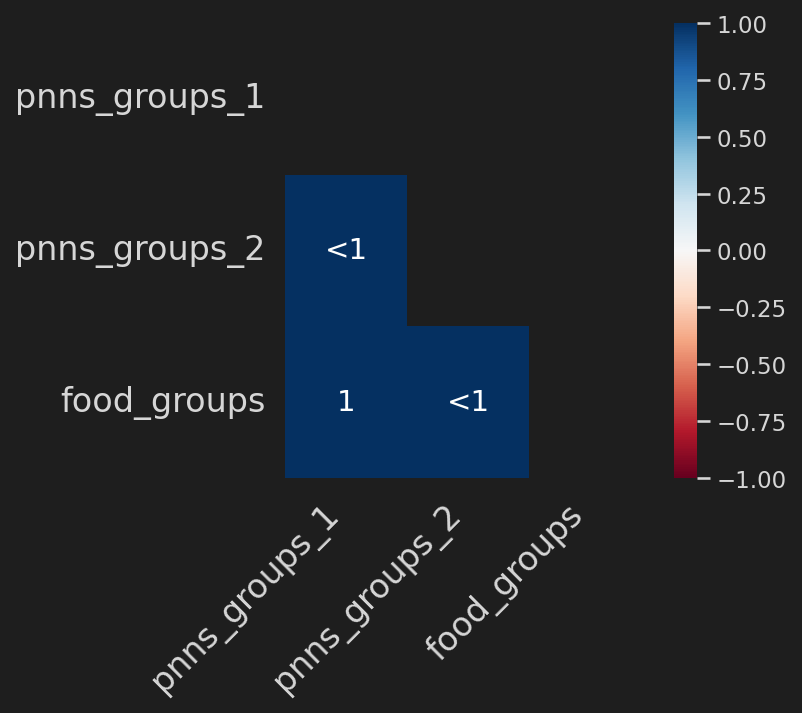

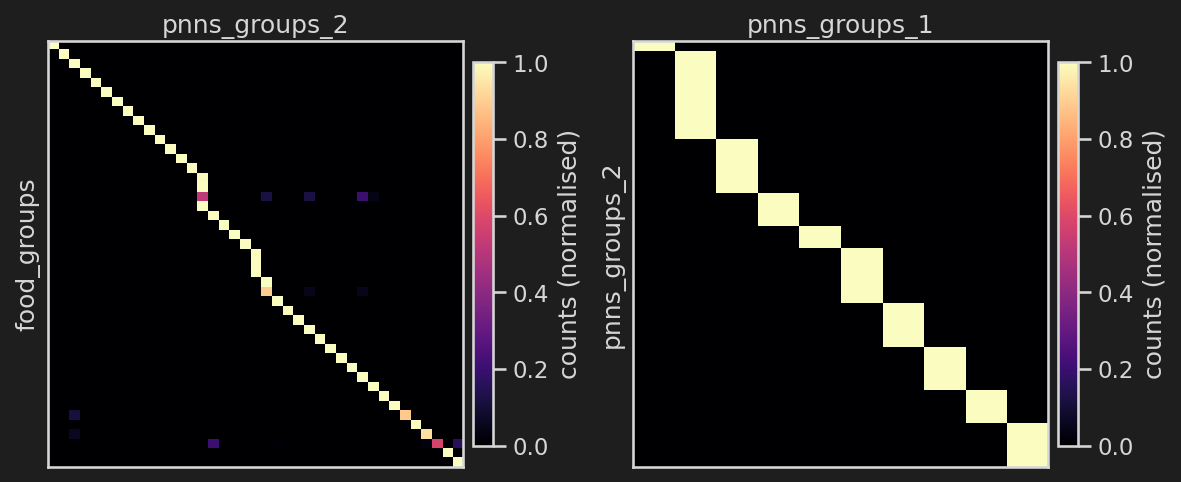

In [74]:
data_chi = data[['pnns_groups_1', 'pnns_groups_2', 'food_groups']].copy()

print('nan in data_chi:')
print( data_chi.isnull().sum() )


fig, ax = plt.subplots( figsize=(10*cm,10*cm))
msno.heatmap( data_chi , ax=ax )

data_chi_isnull = data_chi.isnull()

# drop all rows with at least one NaN
data_chi.drop( data_chi.index[ data_chi_isnull.sum(1) > 0 ] , inplace=True )

# check drop
print('\nnan in data_chi:')
print( data_chi.isnull().sum() )

type_plot = ['xi', 'count'][1]

X2, Y2 = 'pnns_groups_2', 'pnns_groups_1'
X1, Y1 = 'food_groups', 'pnns_groups_2'

maps = [ None, None ]
fig, axs = plt.subplots( 1,2, figsize= (20*cm, 8*cm) )
for i, (X,Y) in enumerate( [ (X1,Y1), (X2,Y2) ] ):
    xi_ij, contingences = tools.chi2( data_chi, X, Y )

    image = contingences.values
    image = image[:-1,:-1] / image[:-1,-1:]
    argmax_col = image.argmax(1)
    maps[i] = pd.Series( { key_in:contingences.keys()[imax_col] for key_in, imax_col in zip(contingences[:-1].index, argmax_col)} )
    argsort_rows = argmax_col.argsort()
    # display( contingences.iloc[argsort_rows,:] )
    if type_plot == 'xi':
        image = xi_ij.values[:-1,:-1]
        label = r'$\xi_{ij} \, / \, \xi_{n}$'
    else:
        label = r'counts (normalised)'
    image = image[ argsort_rows ]

    # figsize = tools.image_size_from_height_and_shape( 12*cm, image.shape, xmargin=1*cm)
    # print( 'figsize', figsize)
    # fig, ax = plt.subplots( figsize=figsize )
    im = axs[i].imshow( image , cmap='magma', aspect='auto' )
    # axs[i].axis('off')
    # cb = plt.colorbar( im, ax=ax, orientation='horizontal', pad=0.01, label=r'$\xi_{ij} \, / \, \xi_{n}$')
    cb = plt.colorbar( im, ax=axs[i], pad=0.02, shrink=[0.9, 0.9][i], label=label)

axs[0].set_xlabel(Y1)
axs[0].set_ylabel(X1)

axs[1].set_xlabel(Y2)
axs[1].set_ylabel(X2)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 


# display( contingences )
# display( maps[0] )
# display( maps[1] )

# map food_group -> pnns_groups_1
# there are some 'pnns_groups_1' values in the 'food_groups' for which 'pnns_groups_1' is NaN
food_to_pnns_groups = pd.concat( (maps[1][maps[0]], 
                pd.Series( {key:key for key in dico_value_counts['pnns_groups_1'].keys()} ) ) )


fig.tight_layout( pad=0.4 )
plt.show()
del image, cb, im, axs, fig
del X1,Y1, X2,Y2, maps

## Gestion des NaN dans "pnns_groups_1"
1. détection des NaN
1. chercher NaN "pnns_groups_1" et non NaN "food_groups"
1. remplacer selon "food_groups" et "food_to_pnns_groups"

In [16]:
print( "sum 'pnns_groups_1 NaN and 'pnns_groups_2' not Nan: {:}".format( 
    ( data_chi_isnull['pnns_groups_1'] & ~data_chi_isnull['pnns_groups_2'] ).sum() ) )

sum 'pnns_groups_1 NaN and 'pnns_groups_2' not Nan: 0


In [17]:
b_map = data_chi_isnull['pnns_groups_1'] & ~data_chi_isnull['food_groups']
# display( food_to_pnns_groups)
data.loc[b_map, 'pnns_groups_1'] = food_to_pnns_groups[ data.loc[b_map,'food_groups'] ].values

***
# Gestion et analyse uni-varié des variables float
Mis à NaN:
- (nitruscore < -15) & (nutriscore > 40)
- values < 0 (sauf nutriscore)
- values > 100 (sauf energy)
- energy > 900 (kcal) <span style="color:orange"> compétence métier </span>
- sodium > salt
- saturated-fat > fat
- sugars > carbohydrates

Check $\sum$("proteins", "carbohydrates", "fat" ) > 100

<span style="color:red"> Quid de la somme > 100 ? quelle limite ? </span>

In [18]:
# A VOIR POUR SPEED UP ?
if False:
    _, bp = pd.DataFrame.boxplot(df, return_type='both')

    outliers = [flier.get_ydata() for flier in bp["fliers"]]
    boxes = [box.get_ydata() for box in bp["boxes"]]
    medians = [median.get_ydata() for median in bp["medians"]]
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

,product_name,proteins_100g,carbohydrates_100g,fat_100g,sum_100g
369,Sucre roux,0.00,100.000000,0.100000,100.1
1072,sweet soy sauce,2.60,99.800000,0.000000,102.4
1103,Gaufres sucrées au chocolat,23.00,53.299999,25.700001,102.0
1362,Pisto con salmon y quinoa,30.10,45.480000,29.100000,104.7
1366,Fisherman's Friend pomme cannelle,0.00,98.800000,1.300000,100.1
...,...,...,...,...,...
797669,Lindt HELLO XMAS Cherry,46.70,54.000000,35.000000,135.7
797687,Zucchero Int. bio Cocco GR230 E,1.80,97.000000,1.500000,100.3
797873,Les croquants chocolat bio,7.30,67.000000,27.000000,101.3
798816,Lenguas Ketydul,5.70,67.100000,27.500000,100.3


,nutriscore_score,nutrition-score-fr_100g
count,277591.000000,277594.000000
mean,9.110976,9.111072
std,8.840131,8.840151
min,-15.000000,-15.000000
25%,1.000000,1.000000
50%,10.000000,10.000000
75%,16.000000,16.000000
max,40.000000,40.000000
IQ,15.000000,15.000000


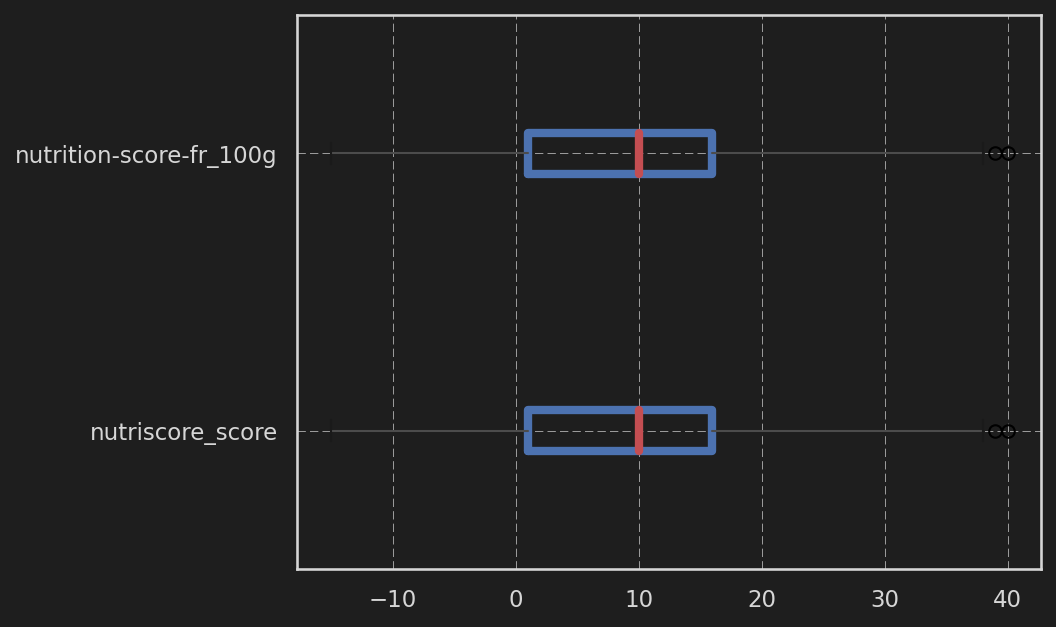

,energy-kcal_100g
count,613009.000000
mean,270.542555
std,191.147619
min,0.000000
25%,100.000000
50%,259.000000
75%,400.000000
max,900.000000
IQ,300.000000


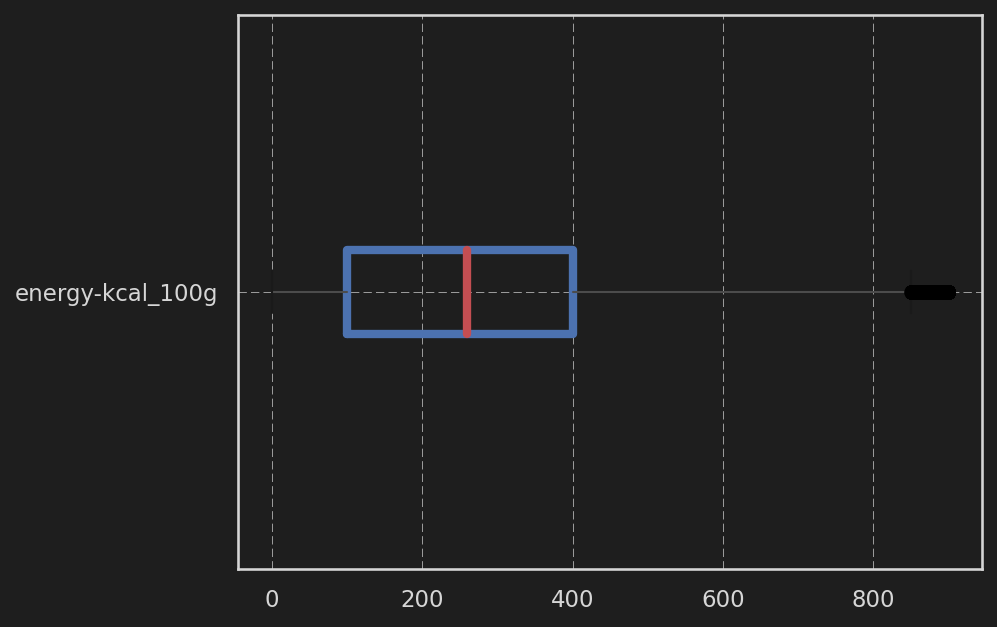

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
count,627690.000000,610569.000000,627529.000000,620299.000000,628226.000000,582539.000000,582533.000000,272274.000000
mean,13.669906,5.056372,28.078364,13.005056,8.710977,1.359247,0.543701,8.237656
std,17.592071,7.756347,27.914560,19.350697,10.013554,4.652734,1.861109,21.662131
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.800000,0.100000,3.530000,0.600000,1.330000,0.082500,0.033000,0.000000
50%,7.000000,1.800000,15.384615,3.570000,6.000000,0.582500,0.233000,0.000000
75%,21.210000,7.058824,53.000000,17.400000,12.500000,1.400000,0.560000,0.400000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000
IQ,20.410000,6.958824,49.470000,16.800000,11.170000,1.317500,0.527000,0.400000


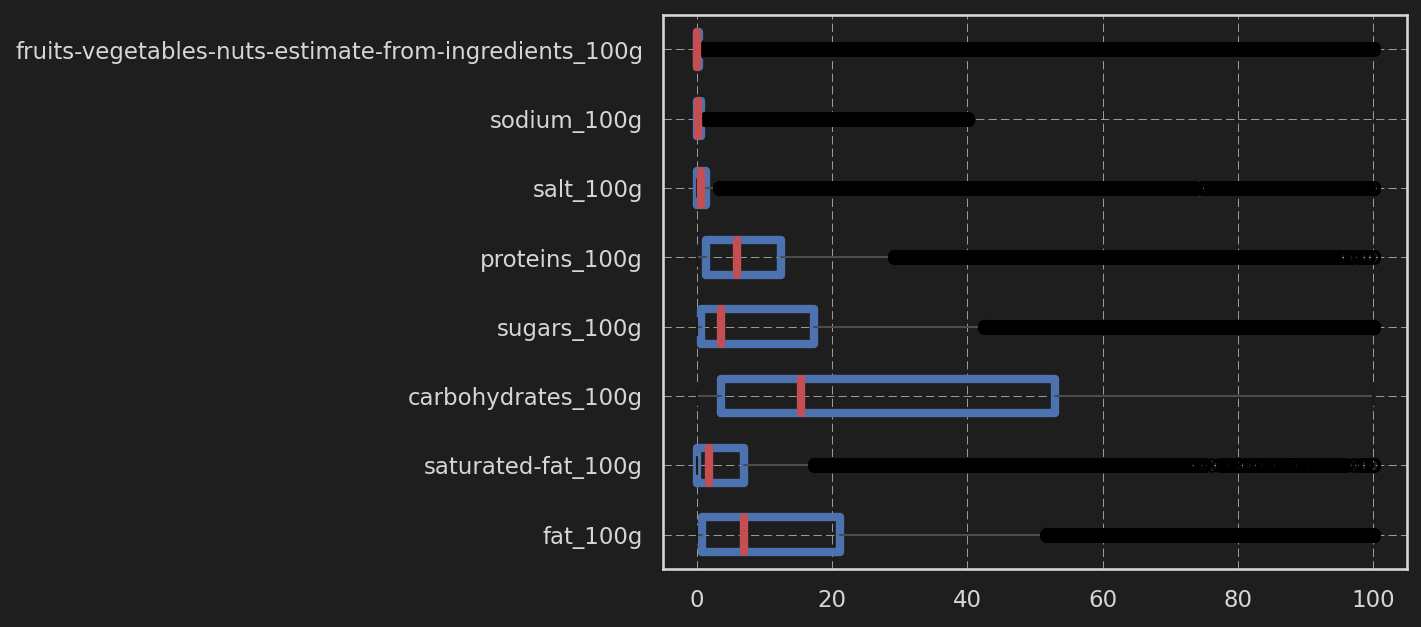

In [19]:
keys = pd.Series( categories_float )
# keys = keys.loc[ keys!='energy_100g' ]
# keys = keys.loc[ keys.str.contains('_100g|score') ]

keys = keys.loc[ keys.str.contains('100g|score') & (keys!='energy_100g') ]
keys_float = keys.copy()
# print(categories_float)
# print('\n', keys.values)


# NUTRI SCORE
key = 'nutriscore_score'
data.loc[ (data[key] < -15.) | (data[key] > 40.) ] = np.nan
key = 'nutrition-score-fr_100g'
data.loc[ (data[key] < -15.) | (data[key] > 40.) ] = np.nan


# ENERGY
key = 'energy-kcal_100g'
data.loc[ (data[key] < 0.) | (data[key] > 900.) ] = np.nan

# (Values < 0.) | (Values > 100.)
for key in keys[ ~keys.str.contains('score|energy') ]:
    data.loc[ (data[key] < 0.) | (data[key] > 100.) ] = np.nan
    
# SODIUM
key = 'sodium_100g'
data.loc[ data[key] > data['salt_100g'], key ] = np.nan

# SUGARS
key = 'sugars_100g'
data.loc[ data[key] > data['carbohydrates_100g'], key ] = np.nan

# SATURATED_FAT
key = 'saturated-fat_100g'
data.loc[ data[key] > data['fat_100g'], key ] = np.nan

# TOTALtext
key = 'sum_100g'
data[key] = data[ ['proteins_100g', 'carbohydrates_100g', 'fat_100g'] ].fillna(0.).sum(axis=1).round(1)


display( data.loc[ np.round( data['sum_100g'], 1)>100. , ['product_name','proteins_100g', 'carbohydrates_100g', 'fat_100g', 'sum_100g']] )

del key


df_describe = data[ keys ].describe()



IQs = df_describe.loc['75%', :] - df_describe.loc['25%', :]
# IQs.rename( index={0:'IQ'}, inplace=True )

# # display(IQs)
df_describe = pd.concat( (df_describe, IQs.to_frame().T) , ignore_index=False )
df_describe.rename( index={0:'IQ'}, inplace=True )

boxprops = dict(linestyle='-', linewidth=4, color='b')
medianprops = dict(linestyle='-', linewidth=4, color='r')


for keys_tmp in [ keys.astype(str).values[keys.str.contains('score')] , ['energy-kcal_100g'], keys[~keys.str.contains('score|energy')].values ]:
    display( df_describe[keys_tmp] )
    data[keys_tmp].boxplot( showfliers=True, vert=False, boxprops=boxprops, medianprops=medianprops )
    # ax.bxp( df_describe[keys_tmp], boxprops=boxprops, medianprops=medianprops )
    plt.show()
del keys_tmp


# key = 'energy_100g'
# data.loc[ data[key] > df_describe[key]['75%'] + 1.5*df_describe[key]['IQ'] , key ] = np.nan

# df_describe = data[categories_float].describe()
# df_describe.boxplot( showfliers=False, vert=False )
# display( df_describe )


## Nouveau DataFrame et count NaN
<a id="link_prepModel"></a>
Préparation pour modélistation

In [80]:
keys_categ_score = ['pnns_groups_1', 'nova_group', 'nutriscore_grade', 'nutriscore_score']
key_categ = keys_categ_score[2]
key_classification = keys_categ_score[2]

# copie des données catégorie, classification et float
data_base = data[keys_categ_score].copy()
# if not key_classification in key_categ:
#     data_base[key_classification] = data[key_classification].copy()
data_base[keys_float] = data[keys_float].copy()
isna_base = data_base.isna()
sum_isna_base = isna_base.sum() # sum sur les colonnes

display( 'Number of not NaN (over {:} rows)'.format( len(data)) )
display( len(data)-sum_isna_base )

key_output = 'energy-kcal_100g'
keys_stats = keys_float[ ~keys_float.str.contains( 'score|fruits') ]
keys_input = keys_stats[ keys_stats != key_output ]

b_inputs = ~isna_base[key_categ] & (~isna_base[keys_input]).all( 1 ) # logical and over all columns
b_outputs = (~isna_base[[key_output, key_classification]]).all( 1 )

data_stats = data_base.loc[ b_inputs & b_outputs , :]

print('Number of available data:')
print('inputs          : {:}'.format( b_inputs.sum() ) )
print('inputs & outputs: {:}'.format( ( b_inputs & b_outputs ).sum() ))


'Number of not NaN (over 799996 rows)'

pnns_groups_1                                            294317
nova_group                                               243336
nutriscore_grade                                         277591
nutriscore_score                                         277591
energy-kcal_100g                                         613009
fat_100g                                                 627690
saturated-fat_100g                                       610569
carbohydrates_100g                                       627529
sugars_100g                                              620299
proteins_100g                                            628226
salt_100g                                                582539
sodium_100g                                              582533
fruits-vegetables-nuts-estimate-from-ingredients_100g    272274
nutrition-score-fr_100g                                  277594
dtype: int64

Number of available data:
inputs          : 276185
inputs & outputs: 262646


## Affichage des histogrammes pour les différentes variabes float
- 2 groupes sont visibles pour les carbohydrates
- les autres sont globalement des distribution avec un `skweness empirique > 0`
- 1 second groupe (très petit) est parfois visible

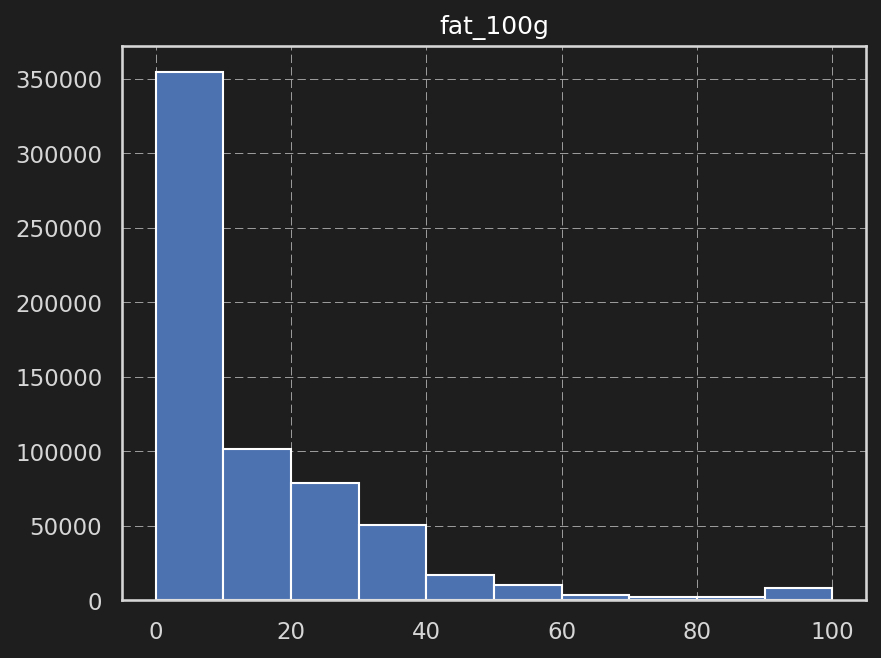

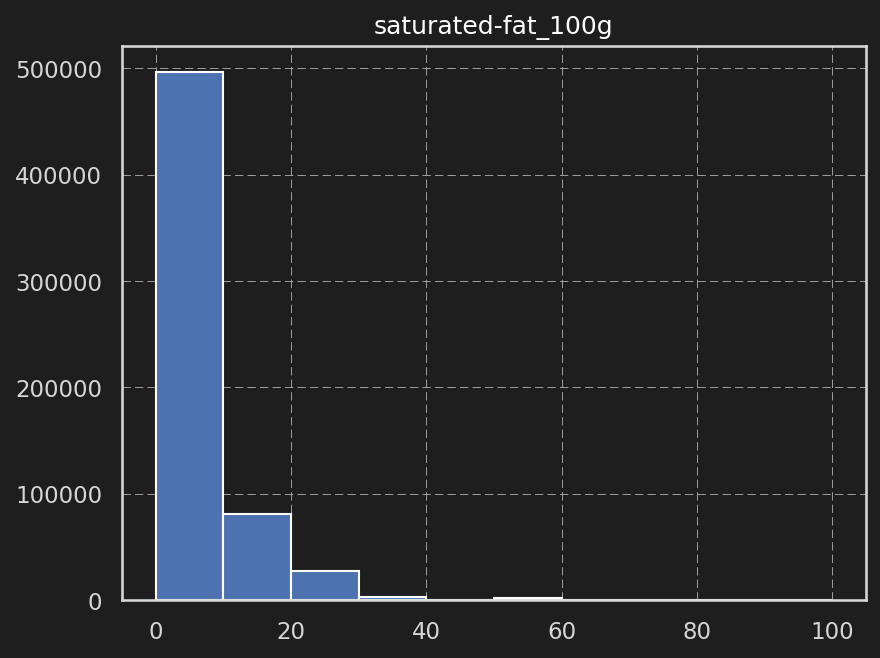

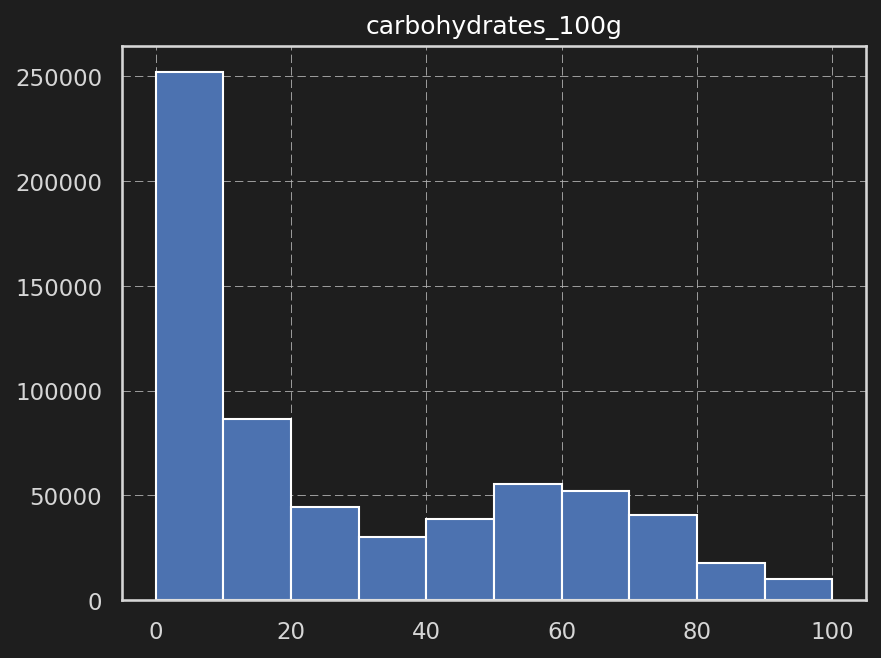

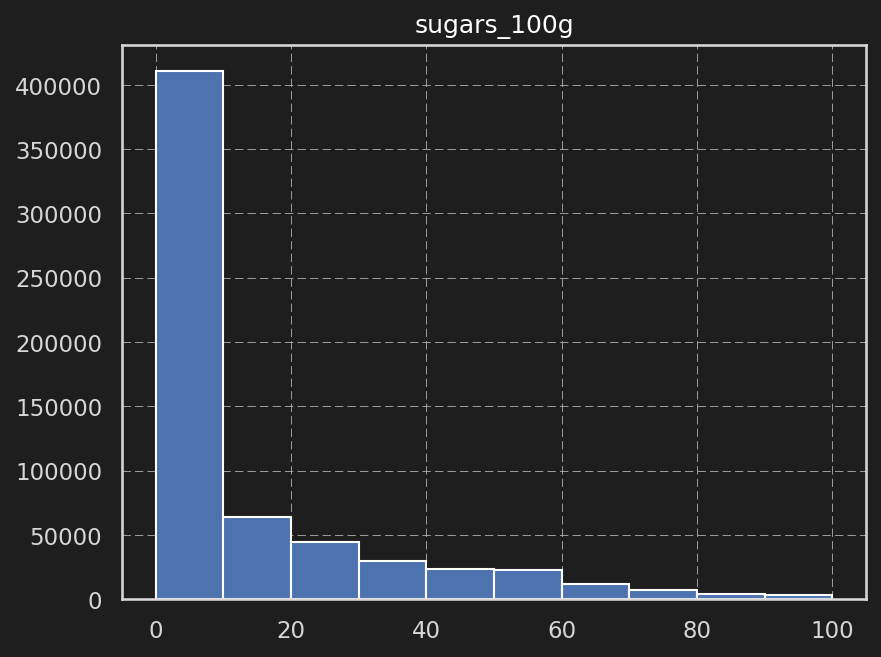

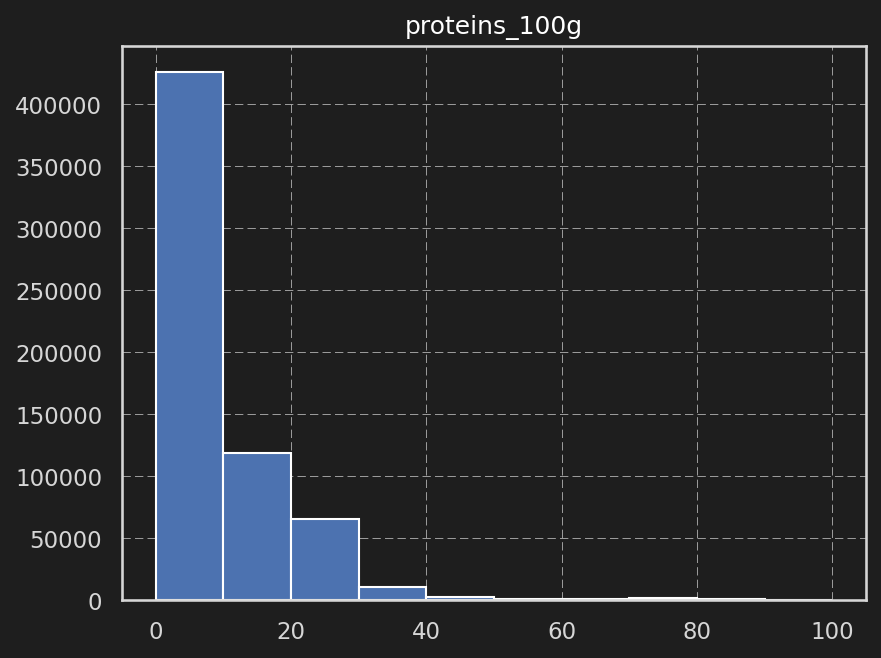

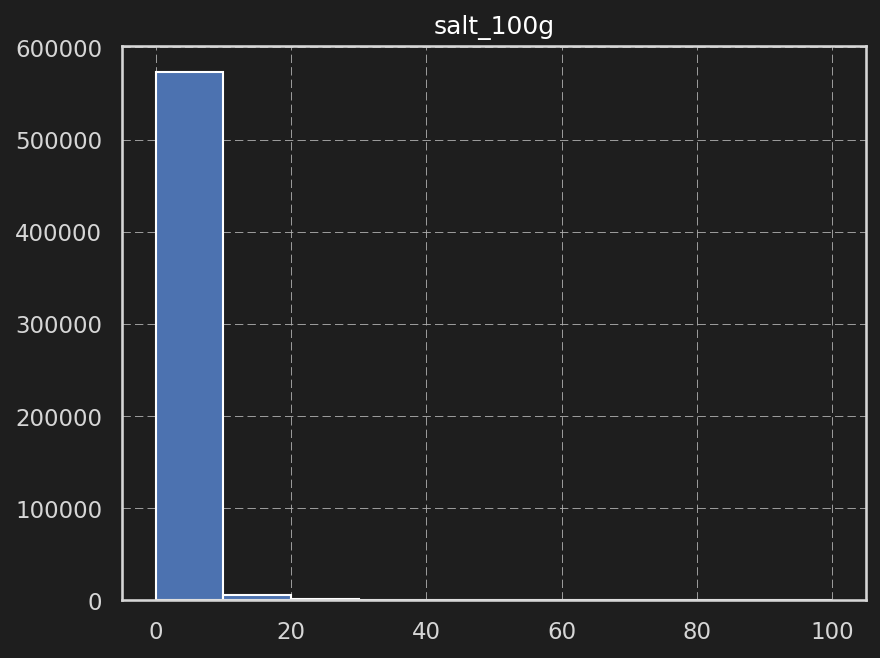

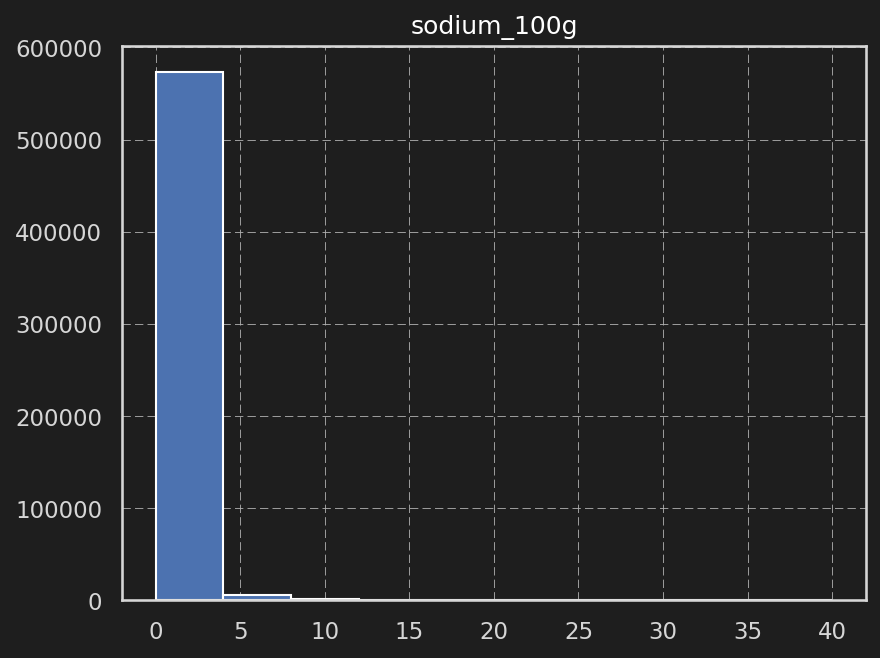

In [24]:
for key in keys_input:
    fig, ax = plt.subplots()
    data_base[ key ].hist( ax=ax )
    ax.set_title(key)

## Analyse bivariée
Tracés:
- energy_kcal vs fat
- energy_kcal vs carbohydrates
- energy_kcal vs proteins
La couleur code la catégorie choisie ( variable key_categ définie [deux sections avant](#link_prepModel) : pnns_group_1 / food_group / nutriscore_grade)

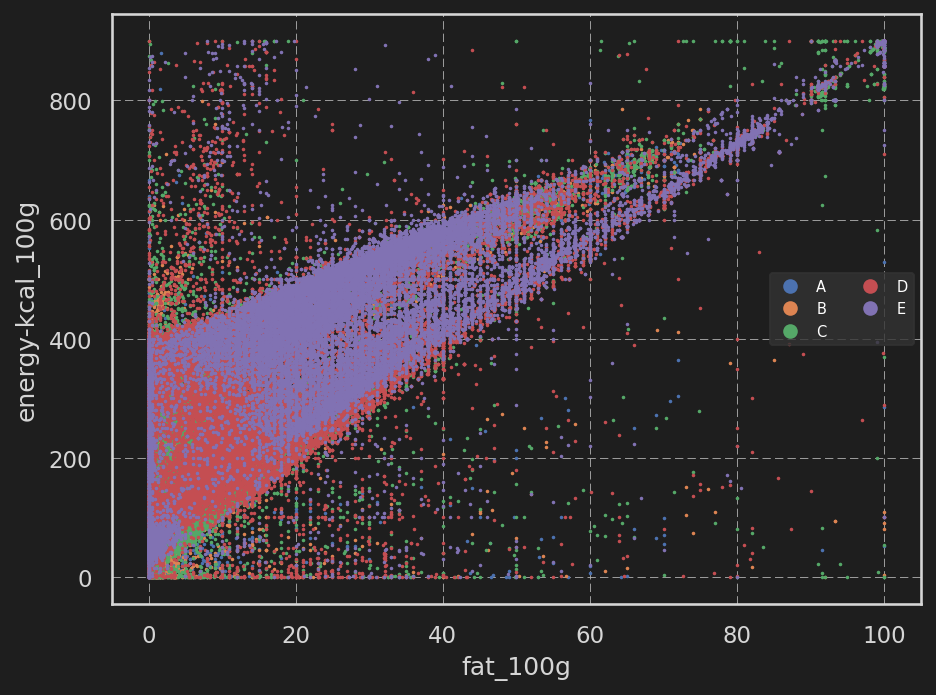

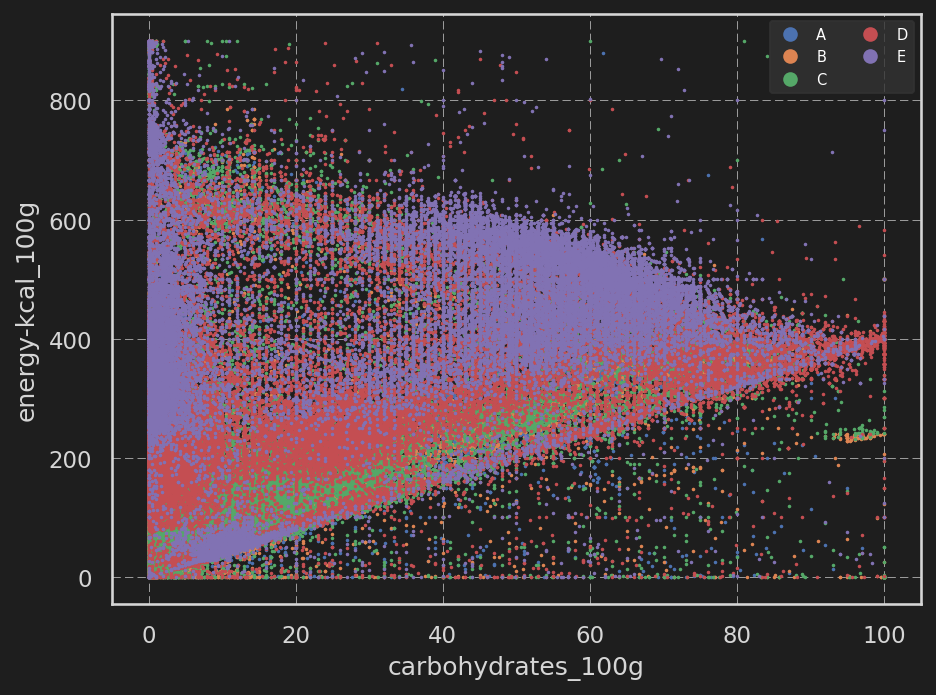

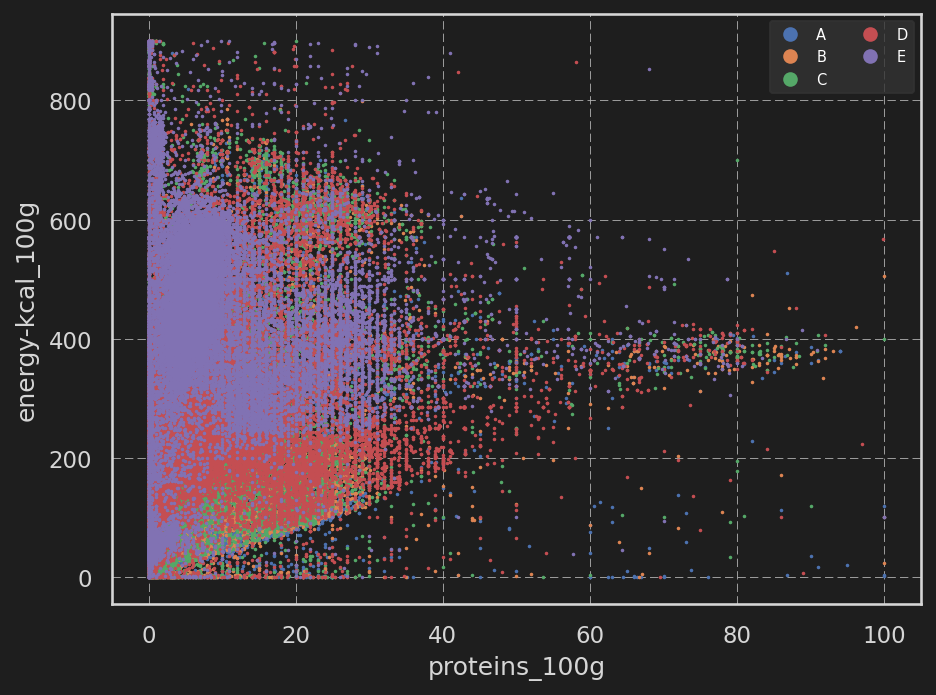

In [81]:
groups = data_stats.groupby( key_categ )

for key in ['fat_100g', 'carbohydrates_100g', 'proteins_100g']:
    fig, ax = plt.subplots()
    ax.set_xlabel( key )
    ax.set_ylabel( key_output )
    for name, group in groups:
        ax.plot( group[key], group[key_output], 'o', markersize=0.7, label=name )
    lgnd = ax.legend( ncol=2, fontsize=7 )
    for handle in lgnd.legendHandles:
        handle.set_markersize(6.0) # change markersize in legend
    fig.tight_layout( )
    plt.show()

# Modelisation
<!-- Les entrées <span style="color:orange"> "salt" </span> et <span style="color:orange"> "sodium" </span> sont <span style="color:orange"> retirées </span>, car il n'y a <span style="color:orange"> pas de corrélation visible </span>sur les graphiques -->

## Remplir quantitatives avec valeur moyenne
<span style="color:red"> Il y a bien plus de NaN dans les variables groupes que dans les variables quantitées (pour celles gardée en tout cas) <br> $\rightarrow$ quid ? </span>

In [26]:
# keys_input_model = keys_stats[ ~keys_stats.str.contains('salt|sodium')]
keys_input_model = keys_stats
display( keys_input_model.tolist() )

['energy-kcal_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

## KNN: classification / Regression

'k-nn to fit "nutriscore_grade"'

k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10


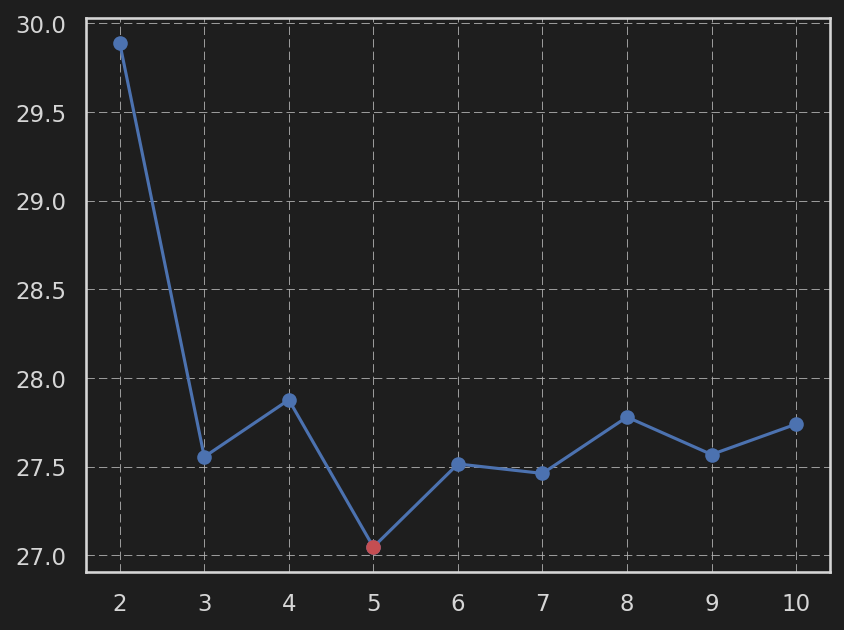

In [82]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors



# display( group[keys_stats] )
display( "k-nn to fit \"{:}\"".format( key_classification) )

xtrain, xtest, ytrain, ytest = train_test_split( data_stats[keys_input_model].values , data_stats[key_classification].values, train_size=0.8)


kmin, kmax = 2, 10
fig, ax = plt.subplots()
errors, dico_knn = [], {}
for k in range(kmin, kmax+1):
    print('k:', k)
    if ytrain.dtype in ['object', 'category']:
        knn = neighbors.KNeighborsClassifier(k)
    else:
        knn = neighbors.KNeighborsRegressor(k)
    dico_knn[k] = knn
    # knn.fit(xtrain, ytrain)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
imin = np.argmin(errors)
ax.plot( range(kmin, kmax+1), errors, 'o-b')
ax.plot( [kmin+imin], [errors[imin]], 'or' )
plt.show()


## Iterative imputer

Categories ['A' 'B' 'C' 'D' 'E']
categories_classification ['A' 'B' 'C' 'D' 'E' 'NaN']


'score:'

38.418046830382636

'prediction:'

array(['B', 'E', 'C', 'D', 'B', 'C', 'C', 'B', 'B', 'C'], dtype='<U3')

'true:'

['B', 'E', 'C', 'D', 'A', 'A', 'A', 'B', 'A', 'C']
Categories (5, object): ['A', 'B', 'C', 'D', 'E']

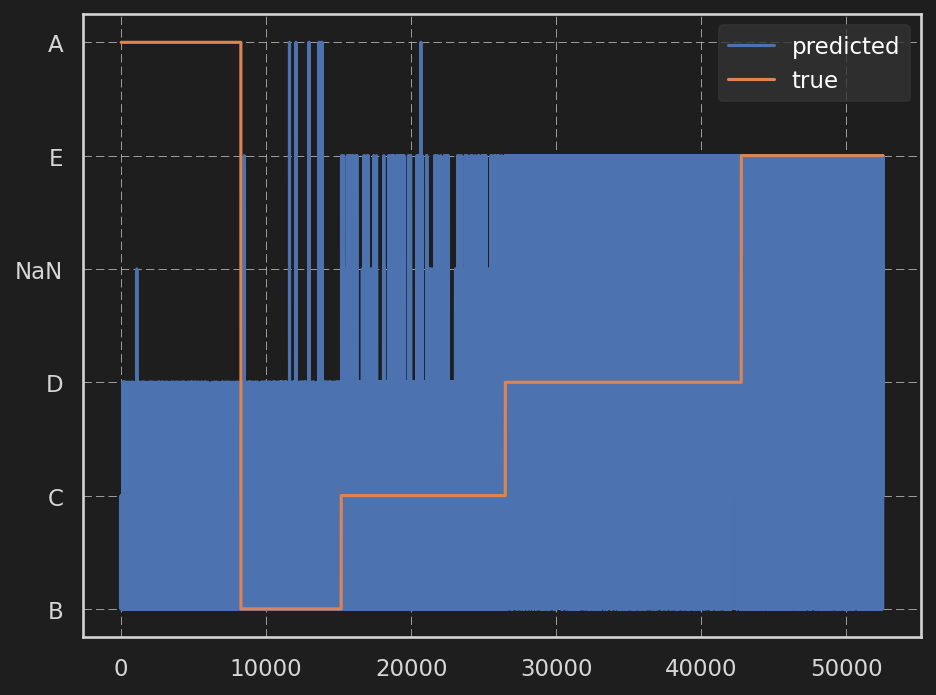

In [106]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=20, random_state=0)

# X_fit = np.hstack( (xtrain, ytrain.reshape(-1,1)) )
X_fit = pd.DataFrame( { key:xtrain[:,i] for i, key in enumerate(keys_stats) } )
ytrain_cat = pd.Series( ytrain, dtype='category' )
X_fit[key_classification] = ytrain_cat.cat.rename_categories( {cat:i for i,cat in enumerate( ytrain_cat.cat.categories )} )

# X_fit = [[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]]
# print('X_fit:\n', X_fit)
imp.fit( X_fit.values )
IterativeImputer(random_state=0)
# X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
# print('completed X_test:\n', np.round(imp.transform(X_test)))

# X_test = np.hstack( (xtest, np.full(shape=xtest[:,:1].shape, fill_value=np.nan) ) )
X_test = pd.DataFrame( { key:xtest[:,i] for i, key in enumerate(keys_stats) } )
X_test[key_classification] = np.nan
Y_pred = imp.transform( X_test.values )

print
if "float" in str(ytest.dtype):
    score = 100*(r2_score(y_true=ytest, y_pred=Y_pred[:,-1] ) )
else:
    print( 'Categories', data[key_classification].cat.categories.values )
    prediction = (Y_pred[:,-1] +0.5 ).astype('int')
    categories_classification = np.array( data[key_classification].cat.categories.tolist() + ['NaN'] )
    print( 'categories_classification', categories_classification )
    prediction[ (prediction<0) | (prediction > len(categories_classification)-1) ] = 5
    prediction = categories_classification[ prediction ]
    score = (ytest == prediction).sum() * 100 / ytest.size
display( 'score:', score )

display( 'prediction:', prediction[:10])
display( 'true:', ytest[:10])

argsort = ytest.argsort()
fig, ax = plt.subplots()
ax.plot( prediction[argsort], label='predicted' )
ax.plot( ytest[argsort], label='true' )
ax.legend()
fig.tight_layout()

## Test SVD

In [ ]:
from sklearn.metrics import r2_score

array = np.empty( (xtrain.shape[0], xtrain.shape[1]+1), dtype='float64' )
array[:,:-1] = xtrain[:,:]
display('IF CATEGORY -> TO NUMERIC')
array[:,-1] = ytrain[:]

U,S,VT = np.linalg.svd( array.T @ array )

fig, axs = plt.subplots( ncols=2 )
for i in range(VT.shape[0]):
    axs[0].plot( VT[i] )
    axs[1].plot( U[i] )

np.set_printoptions( formatter={'float':'{:.3E}'.format})

phi = U[:,:-1]
phi2 = U[:,-1:]

estimator = np.linalg.inv( phi @ phi.T ) @ phi

display( phi @ phi.T )

coefs = estimator @ xtest.T

y_pred = (coefs.T @ phi2 ).ravel()


display( ytest[:10] )
display( y_pred[:10] )

display( r2_score( y_true=ytest, y_pred=y_pred ) )


argsort = ytest.argsort()
fig, ax = plt.subplots()
ax.plot( y_pred[argsort], label='predicted' )
ax.plot( ytest[argsort], label='true' )
ax.legend()
fig.tight_layout()

del array

# <span style="color:orange"> FIN PARTIE UTILE </span>

## Labels
Several labels per product

In [ ]:
key = 'labels_en'

print('Example of labels:\n')
i = 0
for value in data[key]:
        if value is np.nan : continue
        print(value)
        i += 1
        if i == 10: break
dico_value_labels = tools.value_count_labels_in_string_series( data.loc[~data[key].isnull(),key] , ',' )
print(dico_value_labels)

## Visiualisation of NaN with missingno
as barplot 

In [ ]:
msno.bar( data )

## Heatmap without fully filled categories

In [ ]:
msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full)] ] )

## Heatmap without fully filled categories (qualitatives + nutriscore)

In [ ]:
ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )

## A REGARDER

# END OF NOTEBOOK

In [ ]:
fig = ax.get_figure()
fig.tight_layout()
tools.savefig( fig, 'Figures/test' )